In [1458]:
import matplotlib as mpl

import os
import glob
import json
import re

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.colors as mcolors

In [1459]:
import utils as util
import process_datafiles as procd

import assign_phase as ph
import scipy.stats as spstats

In [1460]:
import aggregate_data as aggr

In [1466]:
reload(aggr)

<module 'aggregate_data' from 'aggregate_data.py'>

# Load data

In [1467]:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

processed_dir = os.path.join(rootdir, paradigm, 'processed')

metadata = util.get_metadata(paradigm, rootdir=rootdir, filtered=False, create_meta=False)


Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl


In [1468]:
#### Get all animals in specified cohorts
#cohort_list = ['AK', 'AL', 'AM']
#cohort_list = ['AG', 'AJ']
cohort_list = ['AK', 'AL', 'AM', 'AN'] #, 'AO']
excluded_animals = ['AM9', 'AM10', 'AM11', 'AM12']
cohortdf = aggr.combine_cohorts_to_dataframe(metadata, cohort_list=cohort_list, excluded_animals=excluded_animals)


('combining data from 4 cohorts:', ['AK', 'AL', 'AM', 'AN'])
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... skipping AM10
... skipping AM11
... skipping AM12
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... skipping AM9
... 

aggregate_data.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


# Select phase

In [1469]:
# _ = ph.print_phase_lookup()

In [1255]:
#### Select phase to analyze
phase_list = [1]

#### Get data for current phase
df = aggr.get_cohort_data_by_phase(cohortdf, phase_list=phase_list, cohort_list=cohort_list)

Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AK.pkl
[ 1  2  3  5 17 19  0 -1 16 12]
       animalid  cohort  datasource  session  suffix  protocol  experiment
phase                                                                     
-1            8       8           8        8       8         8           8
 0           17      17          17       17      17        17          17
 1          134     134         134      134     134       134         134
 2           28      28          28       28      28        28          28
 3           47      47          47       47      47        47          47
 5          577     577         577      577     577       577         577
 12           1       1           1        1       1         1           1
 16           5       5           5        5       5         5           5
 17         304     304         304      304     304 

In [1256]:
print("Phase:", sorted(df['phase'].unique()))

object_ids = df['objectid'].unique()
animal_ids = df['animalid'].unique()
print("%i unique animals" % len(animal_ids))
print("Object ids:", object_ids)

no_feedback_flag = len(df[df['no_feedback']==True])>0
print("Has no-feedback trials:", no_feedback_flag)
no_fb = {}

('Cohort list:', ['AK', 'AL', 'AM', 'AN'])
('Phase:', [1])
('Animal list:', ['AK1', 'AK2', 'AK3', 'AK4', 'AK5', 'AK6', 'AK7', 'AK8', 'AK9', 'AK10', 'AK11', 'AK12', 'AL1', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8', 'AL9', 'AL10', 'AL11', 'AL12', 'AL13', 'AL14', 'AL15', 'AL16', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'AM6', 'AM7', 'AM8', 'AN1', 'AN2', 'AN3', 'AN4', 'AN5', 'AN6', 'AN7', 'AN8'])


# Create output dir

In [1471]:
analysis_folder = None

if len(phase_list) == 1:
    if phase_list[0]==1:
        analysis_folder = 'default-view'
    elif phase_list[0] == 5:
        analysis_folder = 'test-transforms'
    else:
        print("Phases: %s\... pick a folder" % str(phase_list))
else:
    if len(phase_list) > 1:
        if 1 in phase_list and 5 in phase_list:
            analysis_folder = 'standard-phases'
        elif 1 in phase_list and 3 in phase_list and 5 not in phase_list:
            analysis_folder = 'training-phases'
    else:
        print("Phases: %s\... pick a folder" % str(phase_list))

outdir = os.path.join(processed_dir, 'basic-training', analysis_folder) #, 'phase-%i' % curr_phase, 'performance')
if not os.path.exists(outdir):
    print("making dir")
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/behavior-data/threeport/processed/basic-training/default-view


In [1474]:
reload(plotting)

<module 'plotting' from 'plotting.py'>

# Set colors and plotting params

In [1475]:
# combine two color maps for 0-50% and 50-100% as in the PNAS paper
pnas_cmap = plotting.get_pnas_cmap()

# Font params
plotting.update_fonts(labelsize=24)

dpi=150


In [1476]:
tower_colors = dict((t, c) for t, c in zip(sorted(towers.keys(), key=util.natural_keys),
                                           sns.color_palette('colorblind', n_colors=len(towers.keys()))))
boxpos_colors = dict((t, c) for t, c in zip(np.arange(0, 4),
                                           sns.color_palette('cubehelix', n_colors=4)))

feature_colors = {'objectid': sns.color_palette('colorblind', n_colors=2),
                  'portmap': ['magenta', 'forestgreen'],
                  'twinx': ['tab:red', 'tab:blue'],
                  'tower': tower_colors,
                  'box_pos': boxpos_colors}


# Create heatmaps

In [1477]:
cohort_list

['AK', 'AL', 'AM', 'AN']

In [1478]:
defaults = ph.get_default_params('AL')

default_size = defaults['size']
default_depth_rotation = defaults['depth_rotation']
default_planar_rotation = defaults['planar_rotation']

expected_sizes = defaults['expected_sizes']
expected_drots = defaults['expected_depth_rotations']

# default_size = 30
# default_depth_rotation = 0.
# default_planar_rotation = 0.

# if cohort in ['AL']:
#     expected_sizes = np.linspace(15, 40, 11.)
#     expected_drots = np.linspace(-60, 60, 25.)
#     default_size = 40
    
# elif cohort in ['AG']:
#     expected_sizes = np.linspace(15, 40, 6.)
#     expected_drots = np.linspace(-60, 60, 9.)


# expected_size_interval = np.diff(expected_sizes).mean()
# expected_drot_interval = np.diff(expected_drots).mean()


In [35]:
# sizes = sorted(np.unique([s for (o, d, s), _ in g.groupby(['object', 'depth_rotation', 'size'])]))
# objects = sorted(np.unique([o for (o, d, s), _ in g.groupby(['object', 'depth_rotation', 'size'])]))
# depth_rotations = sorted(np.unique([d for (o, d, s), _ in g.groupby(['object', 'depth_rotation', 'size'])]))

# print("Objects:", objects)
# print("Sizes:", sizes)
# print("Depth rotations:", depth_rotations)


# Format data for heatmaps

In [1266]:
print("Training size %i | rotation %i" % (df['size'].unique(),df['depth_rotation'].unique()))


Training size 40 | rotation 0


In [1267]:
print(df['pos_x'].unique(), df['pos_y'].unique())

(array([0.]), array([0.]))


In [1268]:
df.head()

,animalid,cohort,depth_rotation,duration,light_position,name,no_feedback,object,outcome,outcome_time,...,response_time,rotation,session,sessionid,size,suffix,time,x_rotation,objectid,phase
0,AK1,AK,0,1749424,None,Blob_2_RotDep_0,False,2,failure,789418115159,...,1.721626,0.0,20170531,20170531,40.0,,789416393118,None,2,1
1,AK1,AK,0,6831090,None,Blob_1_RotDep_0,False,1,success,789478443317,...,2.252827,0.0,20170531,20170531,40.0,,789476190113,None,1,1
2,AK1,AK,0,6547842,None,Blob_1_RotDep_0,False,1,success,789487347412,...,1.959944,0.0,20170531,20170531,40.0,,789485387092,None,1,1
3,AK1,AK,0,666447,None,Blob_2_RotDep_0,False,2,failure,789526235198,...,0.644267,0.0,20170531,20170531,40.0,,789525590531,None,2,1
4,AK1,AK,0,5065000,None,Blob_1_RotDep_0,False,1,success,789555075438,...,0.477405,0.0,20170531,20170531,40.0,,789554597654,None,1,1


# Assign port-mapping

In [1488]:
#### Assign port mapping to df
portmapping = aggr.get_portmapping(df)
df['portmap'] = [0 for _ in np.arange(0, len(df))]
df.loc[df['animalid'].isin(portmapping['Object1_Port1']), 'portmap'] = 1

##### Assign box info
df, bboxes, towers = aggr.assign_box_info(df, metadata)

print("Towers:", df['tower'].unique())
print("Boxes:", sorted(df['boxnum'].unique()))


... getting tower info
... getting setup box info
40 of 44 animalids with unique setup box nos.
...loading existing multi-box info:
-->/n/coxfs01/behavior-data/threeport/processed/meta/multi_box_animals.json
Found 4 animals that were run in > 1 box
('Towers:', array([u'3', u'4', u'2', u'1'], dtype=object))
('Boxes:', [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])


# Look at general stats

In [1283]:
cohort_str = []
for cohort in cohort_list:
    anums = [int(re.search(r'(\d+)', a).group()) for a in animal_ids \
             if re.search(r'(\D+)', a).group()==cohort]
    cohort_str.append('%s%i-%i' % (cohort, min(anums), max(anums)))

#figid = 'phase%i_cohorts_%s\n%s' % (curr_phase, '-'.join(cohort_list), ' | '.join(cohort_str))
figid = 'phase%s_cohorts_%s\n%s' % ('-'.join([str(p) for p in phase_list]), '-'.join(cohort_list), ' | '.join(cohort_str))

print(figid)


phase1_cohorts_AK-AL-AM-AN
AK1-12 | AL1-16 | AM1-8 | AN1-8


In [1490]:
import time

In [1491]:
start_t = time.time()

splitdf = [pd.DataFrame({'animalid': animalid,
                         'cohort': re.search(r'(\D+)', animalid).group(),
                          'session': int(re.search(r'(\d+)', sessionid).group()),
                          'sessionid': sessionid,
                          'objectid': objectid,
                          'boxnum': g['boxnum'].unique()[0],
                          'tower':  g['tower'].unique()[0],
                          'boxpos':  g['boxpos'].unique()[0],
                          'portmap':  g['portmap'].unique()[0],
                          'phase':  g['phase'].unique()[0],
                          'mean_rt': g['response_time'].mean(),
                          'split_accuracy': g['outcome'].value_counts()['success'] / float(g['outcome'].value_counts().sum()) \
                                    if 'success' in g['outcome'].value_counts().keys() else 0.,
                          'n_trials': float(g['outcome'].value_counts().sum())}, index=[i])\
                               for i, ((animalid, sessionid, objectid), g) \
                  in enumerate(df.groupby(['animalid', 'sessionid', 'objectid']))]
splitdf = pd.concat(splitdf, axis=0)
end_t = time.time() - start_t
print("Elapsed: {0:.2f}sec".format(end_t))


Elapsed: 6.47sec


In [1492]:
start_t = time.time()
perfdf = [pd.DataFrame({'animalid': animalid,
                         'cohort': re.search(r'(\D+)', animalid).group(),
                          'session': int(re.search(r'(\d+)', sessionid).group()),
                          'sessionid': sessionid,
                          'boxnum': g['boxnum'].unique()[0],
                          'tower':  g['tower'].unique()[0],
                          'boxpos':  g['boxpos'].unique()[0],
                          'portmap':  g['portmap'].unique()[0],
                          'phase':  g['phase'].unique()[0],
                          'mean_rt': g['response_time'].mean(),
                          'overall_accuracy': g['outcome'].value_counts()['success'] / float(g['outcome'].value_counts().sum()) \
                                    if 'success' in g['outcome'].value_counts().keys() else 0.,
                          'n_trials': float(g['outcome'].value_counts().sum())}, index=[i])\
                               for i, ((animalid, sessionid), g) \
                  in enumerate(df.groupby(['animalid', 'sessionid']))]
perfdf = pd.concat(perfdf, axis=0)
end_t = time.time() - start_t
print("Elapsed: {0:.2f}sec".format(end_t))

Elapsed: 2.91sec


## Filter over-trained sessions out

In [1493]:
plot_overtrained = False

In [1494]:
AN_df = perfdf[perfdf['cohort']=='AN'].copy()
AN_df['train_day'] = [-1 for _ in np.arange(0, len(AN_df))]

AN_df_split = splitdf[splitdf['cohort']=='AN'].copy()
AN_df_split['train_day'] = [-1 for _ in np.arange(0, len(AN_df_split))]

for (animalid), g in AN_df.groupby(['animalid']):
    sorted_sessions = list(sorted(g['sessionid'].unique(), key=util.natural_keys))
    sorted_session_ixs = [sorted_sessions.index(s) for s in g['sessionid']]
    AN_df.loc[g.index, 'train_day'] = sorted_session_ixs
    
for (animalid), g in AN_df_split.groupby(['animalid']):
    sorted_sessions = list(sorted(g['sessionid'].unique(), key=util.natural_keys))
    sorted_session_ixs = [sorted_sessions.index(s) for s in g['sessionid']]
    AN_df_split.loc[g.index, 'train_day'] = sorted_session_ixs
    

#### Create filtered df

In [1495]:
thr = 0.7

AN_last_session = {}
for animalid, g in AN_df.groupby(['animalid']):
    curr_vals = g[g['overall_accuracy']>=thr].sort_values(by='session') #['overall_accuracy']
    if len(curr_vals) == 0:
        last_sess = g.sort_values(by='session')['session'].iloc[-1]
    else:
        last_sess = curr_vals['session'].iloc[0]
    AN_last_session[animalid] = last_sess
       

AN_df_filtered = pd.concat([g[g['session']<=AN_last_session[animalid]] \
               for animalid, g in AN_df.groupby(['animalid'])])


In [1496]:
no_overtrained = AN_last_session.copy()

testdf = pd.concat([g[g['session']<=no_overtrained[animalid]] if animalid in no_overtrained.keys() else g \
               for animalid, g in perfdf.groupby(['animalid'])]).reset_index(drop=True)

testdf_split = pd.concat([g[g['session']<=no_overtrained[animalid]] if animalid in no_overtrained.keys() else g \
               for animalid, g in splitdf.groupby(['animalid'])]).reset_index(drop=True)


In [1497]:
if plot_overtrained:
    hue = 'objectid' # 'session' #'cohort' # None
    factor = 'bbox'

    palette = 'cubehelix' if hue=='train_day' else None
    if palette is None and hue in feature_colors.keys():
        palette = feature_colors[hue]

    plot_each_session = False
    ignore_AN = True

    point_str = 'plot-each-session' if plot_each_session else ''
    hue_str = 'hue-%s' % hue if hue is not None else ''

    if 'object' in hue:
        tdf = AN_df_split.copy()
        metric = 'split_accuracy'
    else:
        tdf = AN_df.copy()
        metric = 'overall_accuracy'

    fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
    sns.boxplot(x=factor, y=metric, data=tdf, ax=ax,
               fliersize=0, width=.7, dodge=True, color='white')
    ax.set_ylim([0, 1])

    # iterate over boxes to make them outlines only
    outline_boxplot(ax)

    color = 'k' if hue is None else None
    if plot_each_session or hue is not None:
        sns.swarmplot(x=factor, y=metric, data=tdf, ax=ax,
                   hue=hue, color=color, alpha=0.7, palette=palette)

    sns.despine(trim=True, offset=4, bottom=True)
    ax.tick_params(axis='x', size=0)
    if hue is not None:
        ax.legend(bbox_to_anchor=(1.1, 1), title=hue, fontsize=8)

    pl.subplots_adjust(bottom=0.2, right=0.75, top=0.9)


    fig.text(0, 0.95, '%s%s' % (figid, add_str), fontsize=6)

    figname = '%s_accuracy_boxplot_%s' % (factor, hue_str)
    pl.savefig(os.path.join(processed_dir, 'basic-training', 'default-view', 'AN', '%s.png' % figname))
    print(figname)


In [1498]:
if plot_overtrained:
    hue = 'train_day' # 'session' #'cohort' # None
    factor = 'bbox'

    palette = 'cubehelix' if hue=='train_day' else 'colorblind'

    plot_each_session = False
    ignore_AN = True

    point_str = 'plot-each-session' if plot_each_session else ''
    hue_str = 'hue-%s' % hue if hue is not None else ''


    fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
    sns.boxplot(x=factor, y='overall_accuracy', data=AN_df_filtered, ax=ax,
               fliersize=0, width=.7, dodge=True, color='white')
    ax.set_ylim([0, 1])

    # iterate over boxes to make them outlines only
    outline_boxplot(ax)

    color = 'k' if hue is None else None
    if plot_each_session or hue is not None:
        sns.swarmplot(x=factor, y='overall_accuracy', data=AN_df_filtered, ax=ax,
                   hue=hue, color=color, alpha=0.7, palette=palette)

    sns.despine(trim=True, offset=4, bottom=True)
    ax.tick_params(axis='x', size=0)
    if hue is not None:
        ax.legend(bbox_to_anchor=(1.1, 1), title=hue, fontsize=8)

    pl.subplots_adjust(bottom=0.2, right=0.75, top=0.9)


    fig.text(0, 0.95, '%s%s' % (figid, add_str), fontsize=6)

    figname = '%s_accuracy_boxplot_%s_phase1-filtered' % (factor, hue_str)
    pl.savefig(os.path.join(processed_dir, 'basic-training', 'default-view', 'AN', '%s.png' % figname))
    print(figname)


# Visualize some overall stats

accuracy_by_boxnum_hue-tower_violin
/n/coxfs01/behavior-data/threeport/processed/basic-training/default-view


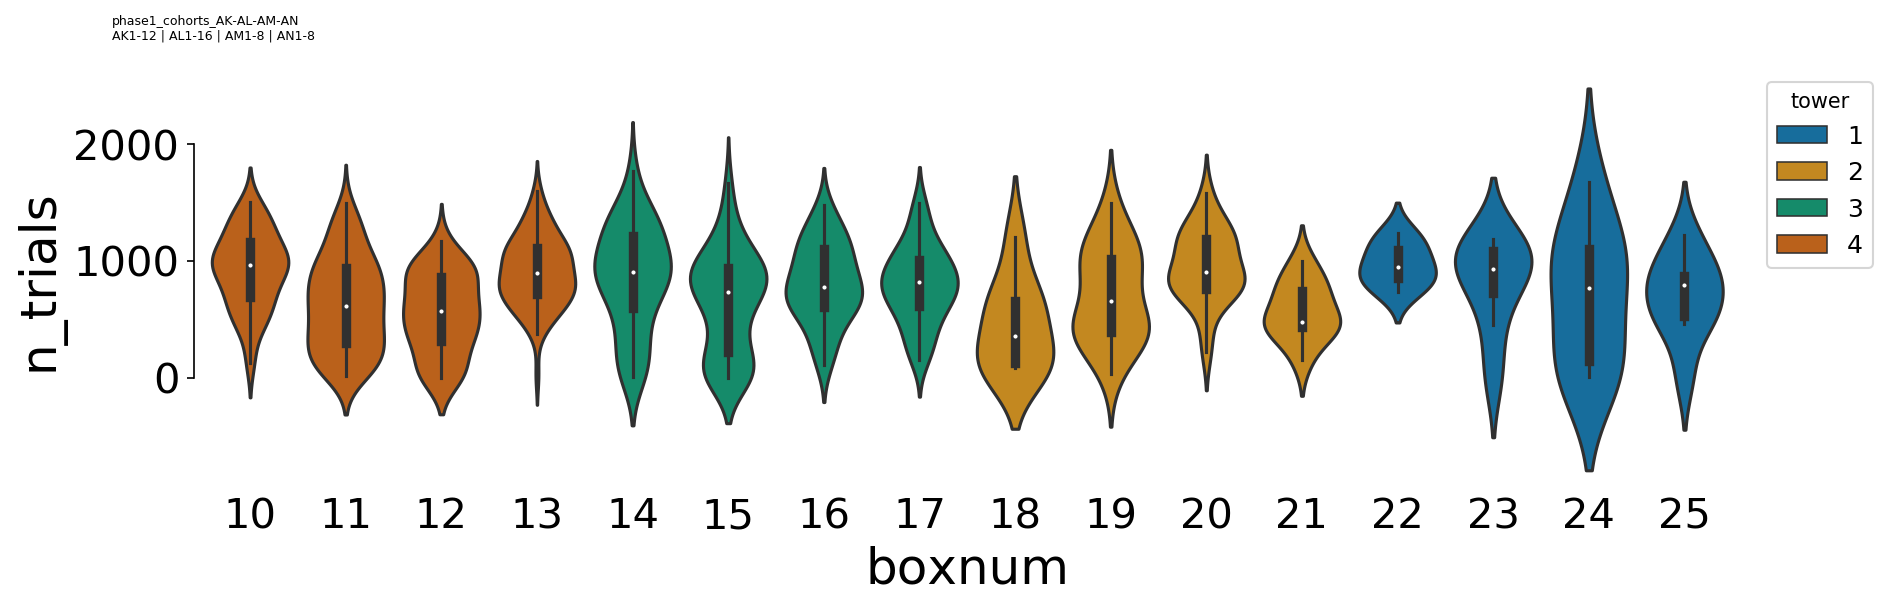

In [1522]:
factor = 'boxnum'
hue = 'tower'
plot_type = 'violin'
metric = 'n_trials'
tdf = testdf.copy()

if metric is None:
    if 'object' in hue or 'object' in factor:
        tdf = testdf_split.copy()
        metric = 'split_accuracy'

    else:
        tdf = testdf.copy()
        metric = 'overall_accuracy'
    
palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'


fig, ax = pl.subplots(figsize=(12,4), dpi=dpi)
if plot_type == 'violin':
    sns.violinplot(x=factor, y=metric, data=tdf, ax=ax,
                hue=hue, dodge=hue!='tower', palette=palette, width=0.8)
else:
    sns.stripplot(x=factor, y=metric, data=testdf, ax=ax,
                    hue=hue, dodge=hue!='tower', palette=palette, alpha=0.5)
if 'accuracy' in metric:
    ax.set_ylim([-0.1, 1.1])

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
fig.text(0, 0.95, figid, fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.9, top=0.9, left=0.05)

figname = 'accuracy_by_%s_hue-%s_%s' % (factor, hue, plot_type)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
#pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)
print(outdir)

overall_accuracy_by_boxnum_hue-None_gray_c
/n/coxfs01/behavior-data/threeport/processed/basic-training/default-view


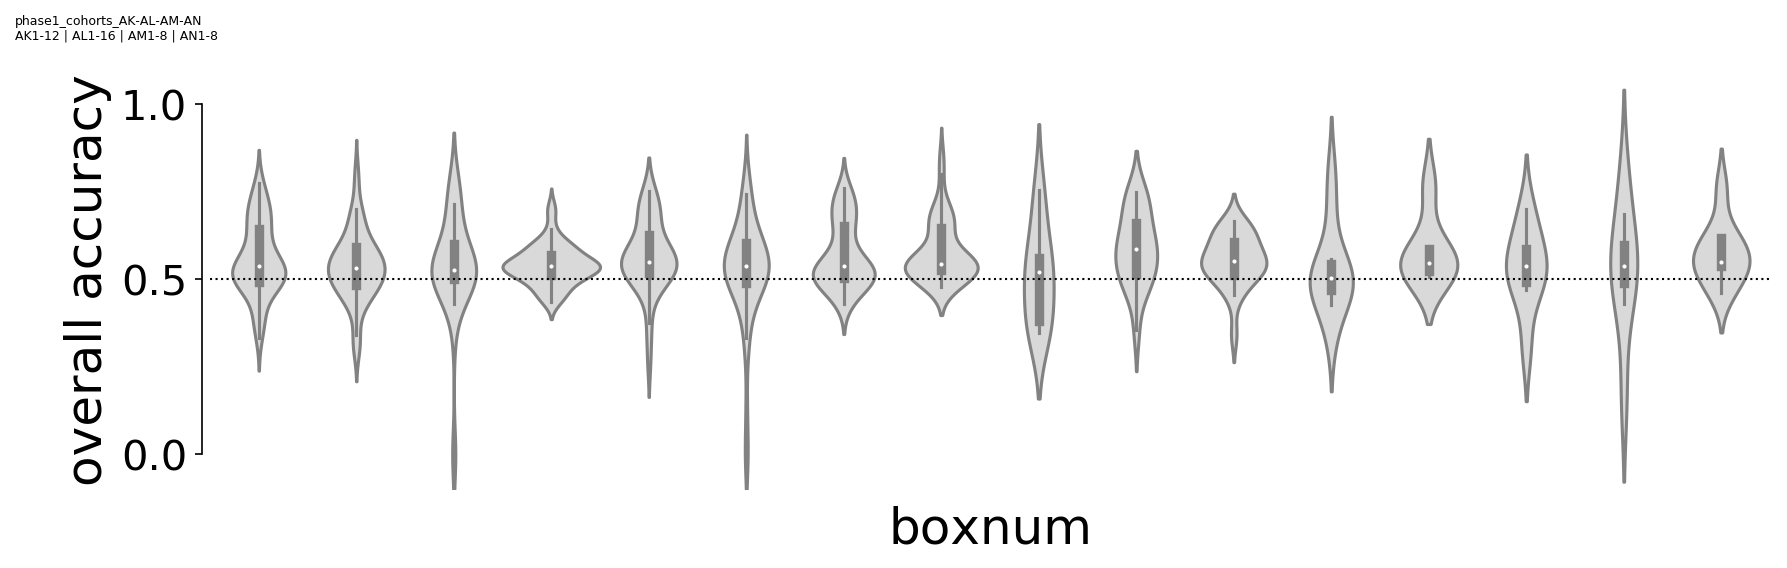

In [1567]:
factor = 'boxnum'
metric = 'overall_accuracy'

hue = None #'tower'
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)


palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

fig, ax = pl.subplots(figsize=(13,4), dpi=dpi)

cval = 0.85
col = (cval, cval, cval)

sns.violinplot(x=factor, y=metric, data=testdf, ax=ax, color=col,
              hue=None, palette=None, width=1., dodge=False)

if 'accuracy' in metric:
    ax.set_ylim([-0.1, 1.1])
    ax.set_yticks([0, 0.5, 1.0])
    ax.axhline(y=0.5, linestyle=':', lw=1, color='k')

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
ax.set_xticklabels('')
ax.set_ylabel(metric.replace('_', ' '))

#ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
fig.text(0, 0.95, figid, fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.9, top=0.9, left=0.1)

figname = '%s_by_%s_hue-%s_gray_c' % (metric, factor, hue)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)
print(outdir)

In [1540]:
lastdf = pd.concat([g.sort_values(by='session')[-2:] for a, g in testdf.groupby(['animalid'])], axis=0)




In [1542]:
lastdf['n_trials'].min()

112.0

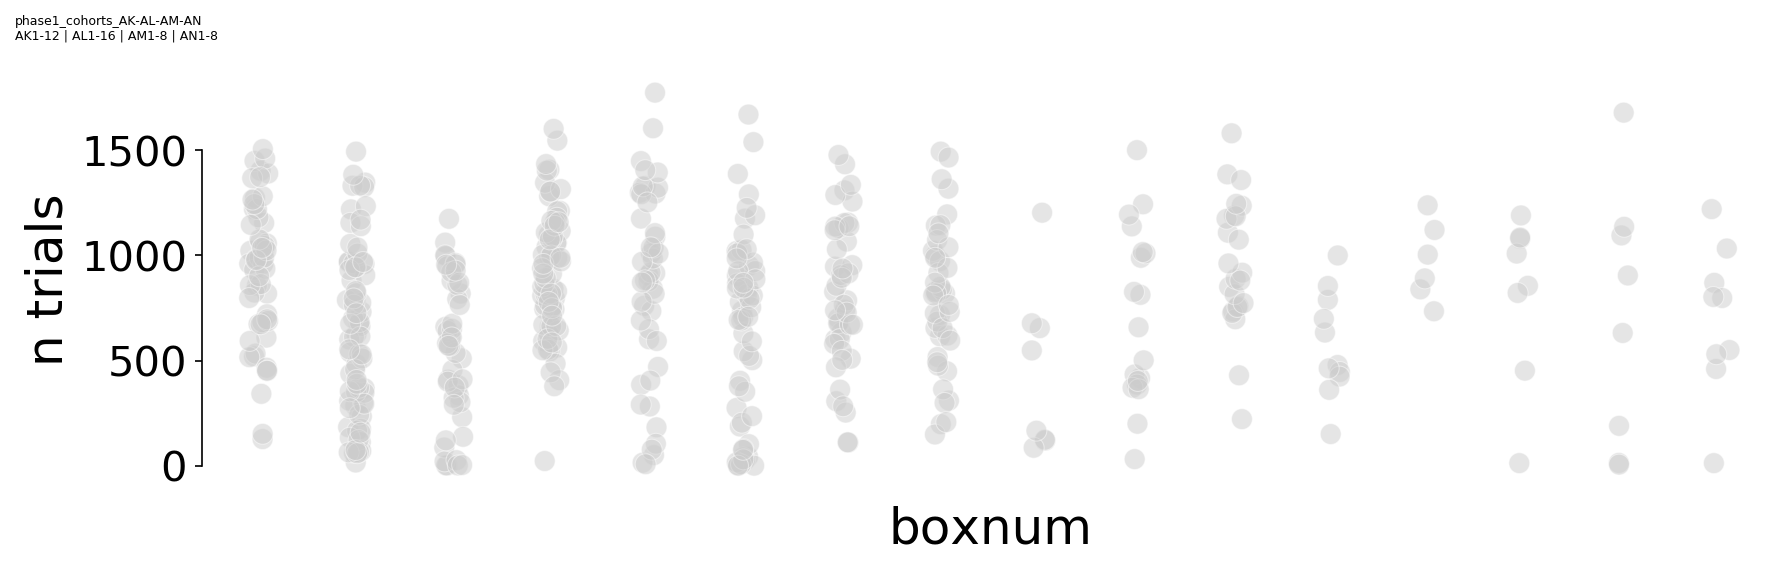

In [1566]:
factor = 'boxnum'
metric = 'n_trials'

hue = None #'tower'
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)


palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

fig, ax = pl.subplots(figsize=(13,4), dpi=dpi)

cval = 0.8
col = (cval, cval, cval)

sns.stripplot(x=factor, y=metric, data=testdf, ax=ax, color=col, lw=0.5,
              hue=None, palette=None, s=10, alpha=.5, edgecolor='w')

#ax.set_ylim([0, ax.get_ylim()[-1]])

if 'accuracy' in metric:
    ax.set_ylim([-0.1, 1.1])
    ax.set_yticks([0, 0.5, 1.0])
    ax.axhline(y=0.5, linestyle=':', lw=1, color='k')

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
ax.set_xticklabels('')
ax.set_ylabel(metric.replace('_', ' '))

#ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
fig.text(0, 0.95, figid, fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.9, top=0.9, left=0.1)

figname = '%s_by_%s_hue-%s_gray_c' % (metric, factor, hue)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)
print(outdir)

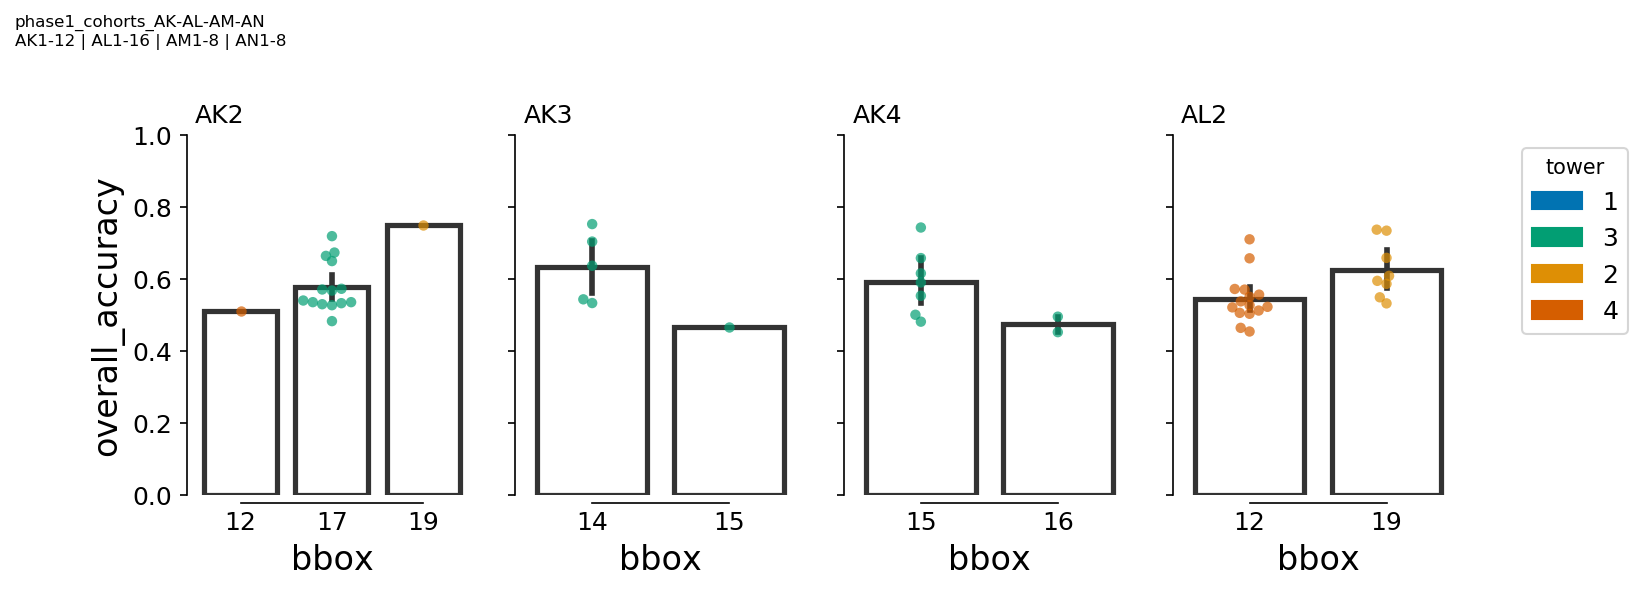

In [1329]:
fig, axes = pl.subplots(1, len(multi_box_animals), figsize=(12,4), dpi=dpi, sharex=False, sharey=True)
for ai, (ax, (animalid, pgroup)) in enumerate(zip(axes.flat, testdf[testdf['animalid'].isin(multi_box_animals)].groupby(['animalid']))):

    sns.barplot(x='bbox', y='overall_accuracy', data=pgroup, ax=ax,
               linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")
    outline_boxplot(ax)

    sns.swarmplot(x='bbox', y='overall_accuracy', data=pgroup, ax=ax, alpha=0.7,
                 hue='tower', palette=palette)
    
    # remove legend from axis 'ax'
    ax.legend_.remove()
    
    if ai!=0:
        ax.set_ylabel('')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, offset=4)
    ax.set_title(animalid, loc='left', fontsize=12)
    
fig.text(0, 0.95, figid, fontsize=8)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, wspace=0.2, top=0.8)
leg_patches = [mpatches.Patch(color=col, label=lab) for lab, col in feature_colors['tower'].items()]
pl.legend(handles=leg_patches, bbox_to_anchor=(1.2, 1), title='tower')


pl.savefig(os.path.join(outdir, 'multi_bbox_accuracy_by-animal-plot-session-avg.png'))

In [1204]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases'

## Plot accuracy by feature

tower_accuracy_hue-box_pos_violin
/n/coxfs01/behavior-data/threeport/processed/basic-training/default-view


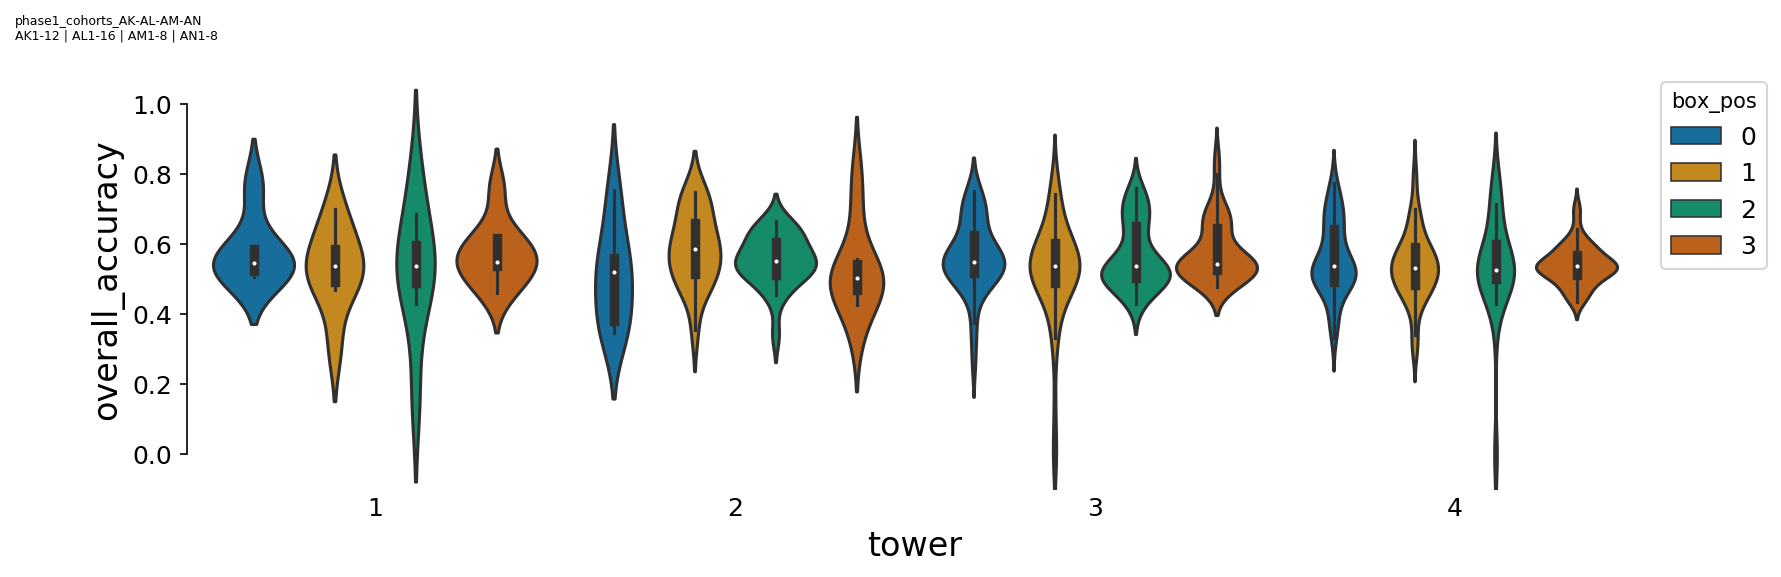

In [1416]:
hue = 'box_pos' #'cohort'  #'cohort' #'cohort' # None
factor = 'tower'
plot_type = 'violin'

# plot_each_session = True

palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

# cval = 0.8
# col = (cval, cval, cval)
col = 'k'
color = col if hue is None else None

hue_str = 'hue-%s' % hue if hue is not None else ''

tdf= testdf.copy()
fig, ax = pl.subplots(figsize=(12,4), dpi=dpi)
if plot_type == 'violin':
    sns.violinplot(x=factor, y='overall_accuracy', data=testdf, ax=ax, color=color,
                hue=hue, dodge=hue!='tower', palette=palette, width=0.9)
else:
    sns.stripplot(x=factor, y='overall_accuracy', data=testdf, ax=ax, color=color,
                    hue=hue, dodge=hue!='tower', palette=palette, alpha=0.5, size=10)
ax.set_ylim([-0.1, 1.1])

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
if hue is not None:
    ax.legend(bbox_to_anchor=(1.1, 1), title=hue)

pl.subplots_adjust(bottom=0.2, right=0.9, top=0.9, left=0.1)
    
    
fig.text(0, 0.95, '%s%s' % (figid, add_str), fontsize=6)

figname = '%s_accuracy_%s_%s' % (factor, hue_str, plot_type)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)
print(outdir)

In [1309]:
towers

{u'1': [22, 23, 24, 25],
 u'2': [18, 19, 20, 21],
 u'3': [14, 15, 16, 17],
 u'4': [10, 11, 12, 13]}

split-tower_accuracy_hue-box_pos


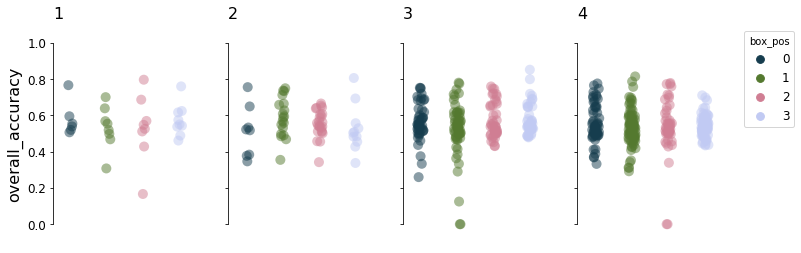

In [1451]:
factor = 'box_pos'
hue = 'box_pos'

sortby = 'tower'

palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

fig, axes = pl.subplots(1, len(testdf[sortby].unique()), figsize=(12,4), sharey=True)
for ai, (ax,(sortfeat, g)) in enumerate(zip(axes.flat, testdf.groupby([sortby]))):
            
    sns.stripplot(x=factor, y='overall_accuracy', data=g, ax=ax,
                  palette=palette, hue=hue, s=10, alpha=0.5)
    
    ax.legend_.remove()
    if ai != 0:
        ax.set_ylabel('')
    
    ax.set_ylim([-0.1, 1.1])
    ax.tick_params(axis='x', size=0)
    ax.set_xticklabels('')
    ax.set_xlabel('')
    sns.despine(trim=True, bottom=True)
    ax.set_title(sortfeat, loc='left')
    
ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
# sns.violinplot(x=factor, y=metric, data=tdf[tdf['bbox']!=0], ax=ax,
#            hue=hue, split=split_plot, scale="count", inner="quartile", palette=curr_colors)

figname = 'split-%s_accuracy_hue-%s' % (sortby, hue)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
print(figname)

split-tower_by-box_pos_accuracy_hue-portmap


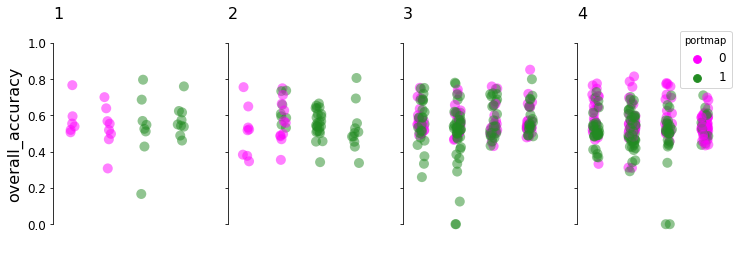

In [1455]:
factor = 'box_pos'
hue = 'portmap'

sortby = 'tower'

palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

if hue == 'objectid':
    tdf = testdf_split.copy()
    metric = 'split_accuracy'
else:
    tdf = testdf.copy()
    metric = 'overall_accuracy'
    
fig, axes = pl.subplots(1, len(tdf[sortby].unique()), figsize=(12,4), sharey=True)
for ai, (ax,(sortfeat, g)) in enumerate(zip(axes.flat, tdf.groupby([sortby]))):
            
    sns.stripplot(x=factor, y=metric, data=g, ax=ax,
                  palette=palette, hue=hue, s=10, alpha=0.5)
    
    ax.legend_.remove()
    if ai != 0:
        ax.set_ylabel('')
    
    ax.set_ylim([-0.1, 1.1])
    ax.tick_params(axis='x', size=0)
    ax.set_xticklabels('')
    ax.set_xlabel('')
    sns.despine(trim=True, bottom=True)
    ax.set_title(sortfeat, loc='left')
    
ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
# sns.violinplot(x=factor, y=metric, data=tdf[tdf['bbox']!=0], ax=ax,
#            hue=hue, split=split_plot, scale="count", inner="quartile", palette=curr_colors)

figname = 'split-%s_by-%s_accuracy_hue-%s' % (sortby, factor, hue)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
print(figname)

bbox_overall-accuracy_hue-portmap_split-violin
/n/coxfs01/behavior-data/threeport/processed/basic-training/default-view


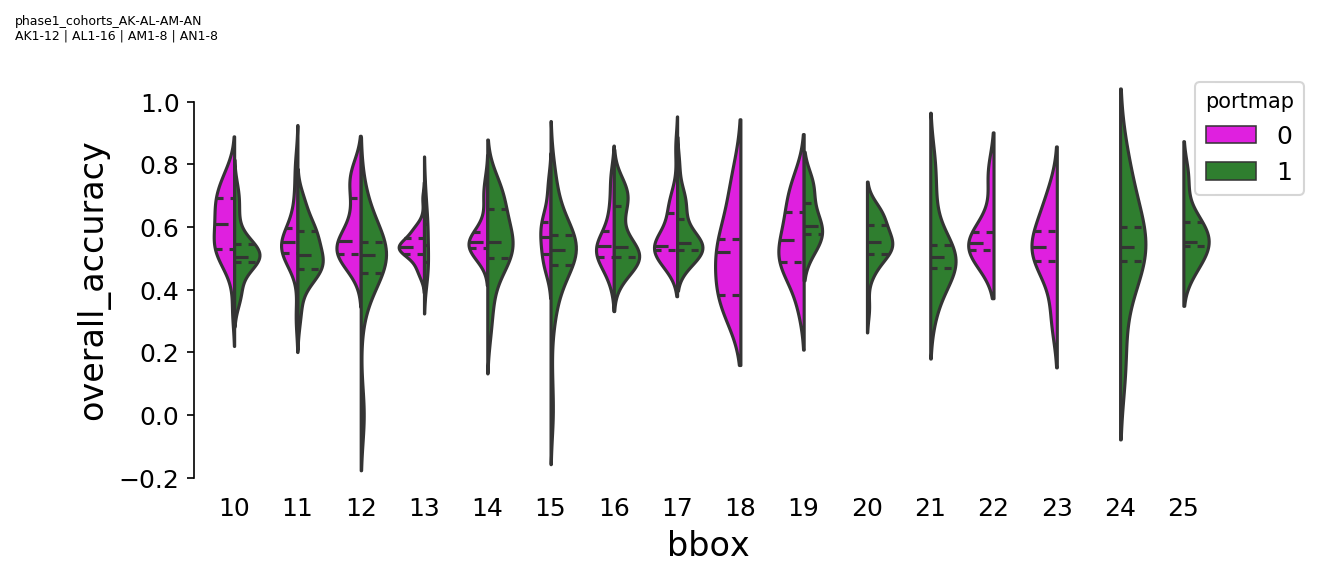

In [1457]:
hue = 'portmap' #'portmap'
factor = 'bbox' #'bbox'


curr_colors = feature_colors[hue]
split_plot = hue is not None

if hue == 'objectid':
    tdf = testdf_split.copy()
else:
    tdf = testdf.copy()
    

metric = 'split_accuracy' if hue=='objectid' else 'overall_accuracy'

fig, ax = pl.subplots(figsize=(10,4), dpi=dpi)
sns.violinplot(x=factor, y=metric, data=tdf[tdf['bbox']!=0], ax=ax,
           hue=hue, split=split_plot, scale="count", inner="quartile", palette=curr_colors)

color = 'k' if hue is None else None
hue_str = 'hue-%s' % hue if hue is not None else ''
plot_type = 'violin' if hue is None else 'split-violin'

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
if hue is not None:
    ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
    
fig.text(0, 0.95, '%s%s' % (figid, add_str), fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.8, top=0.9)

figname = '%s_%s_%s_%s%s' % (factor, metric.replace('_', '-'), hue_str, plot_type, add_str)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)
print(outdir)

In [911]:
tdf['animalid'].unique()

array(['AK1', 'AK10', 'AK11', 'AK12', 'AK2', 'AK3', 'AK4', 'AK5', 'AK6',
       'AK7', 'AK8', 'AK9', 'AL1', 'AL10', 'AL11', 'AL12', 'AL13', 'AL14',
       'AL15', 'AL16', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8',
       'AL9', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'AM6', 'AM8'],
      dtype=object)

# Stat test interactions

In [1310]:
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import statsmodels.api as sm


In [1319]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor

standarddf_no0 = testdf[testdf['bbox']!=0].copy()
#standarddf_no0 = standarddf_split[standarddf_split['bbox']!=0].copy()

#model = ols('overall_accuracy ~ C(box_pos)*C(tower)', standarddf_no0).fit()
# model = ols('overall_accuracy ~ C(tower)', standarddf_no0).fit()
model = ols('overall_accuracy ~ C(bbox)', standarddf_no0).fit()

# Seeing if the overall model is significant
print("Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}".format(model=model))
    

Overall model F( 15, 528) =  1.080, p =  0.3725


In [1320]:
# The Durban-Watson tests is to detect the presence of autocorrelation, 
# Jarque-Bera tests the assumption of normality, 
# Omnibus tests the assumption of homogeneity of variance, 
# and the Condition Number assess multicollinearity. 
# Condition Number values over 20 are indicative of multicollinearity.

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       overall_accuracy   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.080
Date:                Mon, 23 Mar 2020   Prob (F-statistic):              0.372
Time:                        18:59:02   Log-Likelihood:                 442.63
No. Observations:                 544   AIC:                            -853.3
Df Residuals:                     528   BIC:                            -784.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5579      0.015     38.351      0.000       0.529       0.586
C(bbox)[T.11]    -0.0206      0.019     -1.086      0.278      -0.058       0.017
C(bbox)[T.12]    -0.0206      0.022     -0.957      0.339      -0.063       0.022
C(bbox)[T.13]    -0.0162      0.019     -0.836      0.404      -0.054       0.022
C(bbox)[T.14]     0.0082      0.022      0.379      0.705      -0.034       0.050
C(bbox)[T.15]    -0.0335      0.020     -1.651      0.099      -0.073       0.006
C(bbox)[T.16]     0.0098      0.022      0.450      0.653      -0.033       0.052
C(bbox)[T.17]     0.0199      0.022      0.909      0.364      -0.023       0.063
C(bbox)[T.18]    -0.0469      0.041     -1.139      0.255      -0.128       0.034
C(bbox)[T.19]     0.0306      0.029      1.060      0.289      -0.026       0.087
C(bbox)[T.20]    -0.0029      0.027     -0.109      0.913      -0.055       0.049
C(bbox)[T.21]    -0.0317      0.036     -0.883      0.377      -0.102       0.039
C(bbox)[T.22]     0.0229      0.047      0.490      0.624      -0.069       0.115
C(bbox)[T.23]    -0.0257      0.041     -0.624      0.533      -0.107       0.055
C(bbox)[T.24]    -0.0284      0.041     -0.691      0.490      -0.109       0.052
C(bbox)[T.25]     0.0154      0.039      0.393      0.695      -0.061       0.092
==============================================================================
Omnibus:                       98.481   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.004
Skew:                          -0.722   Prob(JB):                     5.22e-98
Kurtosis:                       7.205   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1321]:
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(bbox),0.191907,15.0,1.079562,0.372454
Residual,6.257298,528.0,NaN,NaN


In [1322]:
mc = statsmodels.stats.multicomp.MultiComparison(standarddf_no0['overall_accuracy'], standarddf_no0['box_pos'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0208  -0.0548 0.0131 False 
  0      2    -0.0078  -0.0439 0.0283 False 
  0      3     -0.005  -0.0404 0.0304 False 
  1      2     0.0131  -0.0202 0.0464 False 
  1      3     0.0158  -0.0166 0.0483 False 
  2      3     0.0028   -0.032 0.0375 False 
--------------------------------------------


In [1323]:
mc = statsmodels.stats.multicomp.MultiComparison(standarddf_no0['overall_accuracy'], standarddf_no0['tower'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.0017  -0.0602 0.0635 False 
  1      3     0.0037  -0.0507 0.058  False 
  1      4    -0.0098  -0.0632 0.0437 False 
  2      3     0.002   -0.0389 0.043  False 
  2      4    -0.0114  -0.0512 0.0284 False 
  3      4    -0.0134  -0.0402 0.0133 False 
--------------------------------------------


In [1324]:
standarddf['tower'].unique()

array([u'3', u'4', u'2'], dtype=object)

In [1325]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['box_pos'])]
spstats.kruskal(*vs)

KruskalResult(statistic=1.2707700500961276, pvalue=0.7360854395120571)

In [1326]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['tower'])]
spstats.kruskal(*vs)

KruskalResult(statistic=3.32534244945416, pvalue=0.3441309941800922)

In [1327]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['bbox'])]
spstats.kruskal(*vs)

KruskalResult(statistic=14.656625154876457, pvalue=0.4764220941604079)

# Look at performance as a function of time

In [442]:
cohort_list

['AK', 'AL', 'AM', 'AN']

## Individuals

In [985]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases'

In [986]:
if not os.path.exists(os.path.join(outdir, 'individuals')):
    os.makedirs(os.path.join(outdir, 'individuals'))


In [1065]:
animal_ids

array(['AK1', 'AK10', 'AK11', 'AK12', 'AK2', 'AK3', 'AK4', 'AK5', 'AK6',
       'AK7', 'AK8', 'AK9', 'AL1', 'AL10', 'AL11', 'AL12', 'AL13', 'AL14',
       'AL15', 'AL16', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8',
       'AL9', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'AM6', 'AM7', 'AM8',
       'AN1', 'AN2', 'AN3', 'AN4', 'AN5', 'AN6', 'AN7', 'AN8'],
      dtype=object)

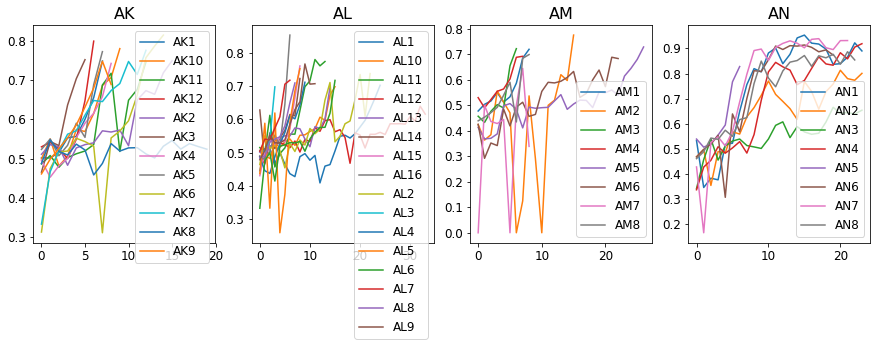

In [1068]:
fig, axes = pl.subplots(1, len(cohort_list), figsize=(15, 4))

for (cohort, animalid), g in perfdf[perfdf['phase']==1].groupby(['cohort', 'animalid']):
    axi = list(cohort_list).index(cohort)
    ax = axes[axi]
    
    session_list = [s for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    ax.plot(np.arange(0, len(session_list)), mean_acc, label=animalid)
    #ax.plot(session_list, mean_acc)
    ax.set_title(cohort)
    ax.legend()

In [504]:
figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}


(2, 6)
(2, 8)
(2, 4)


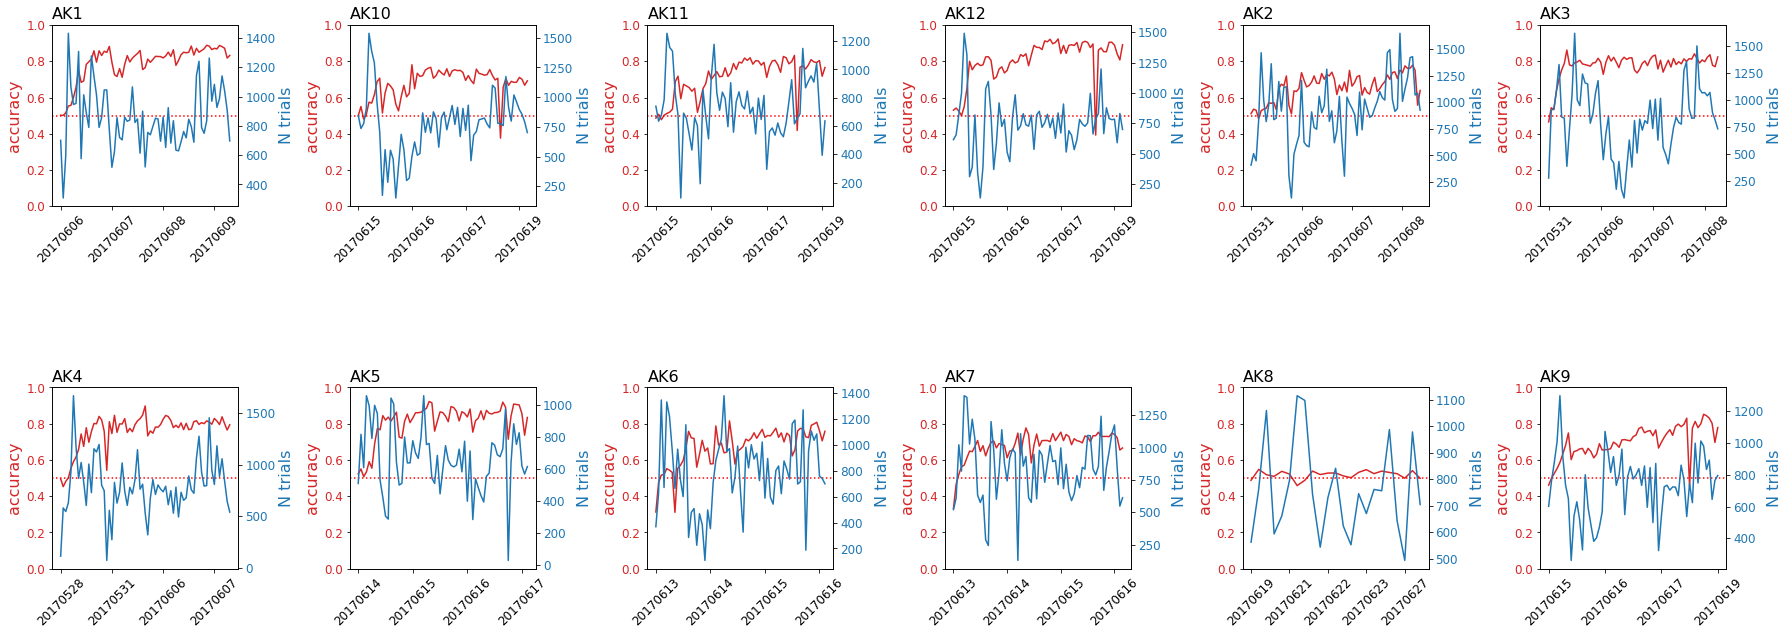

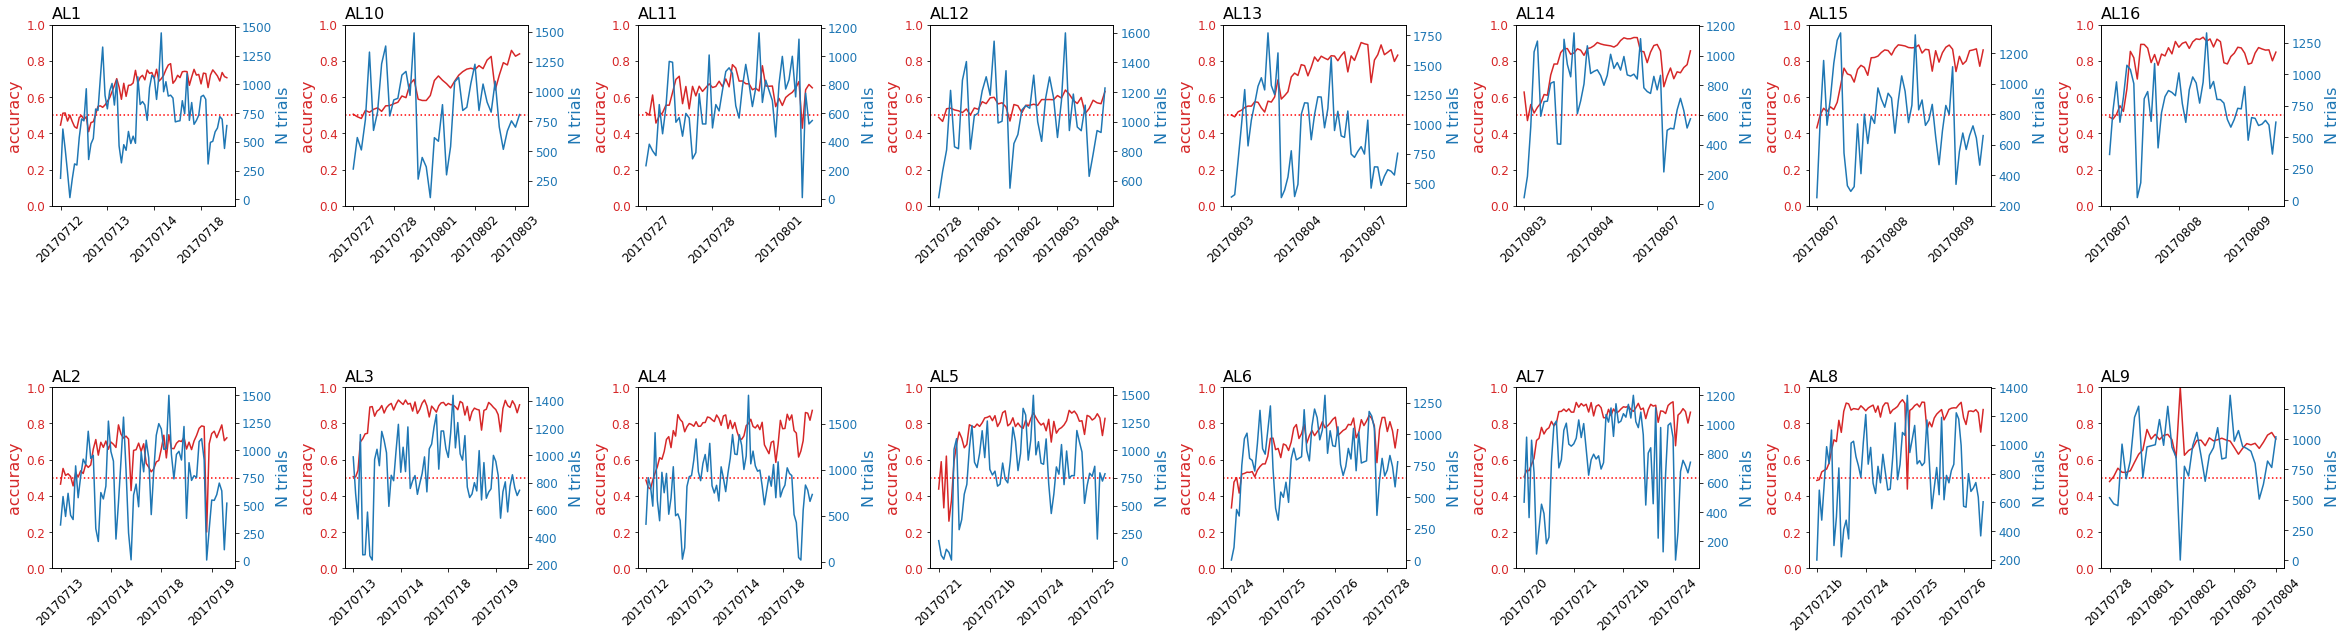

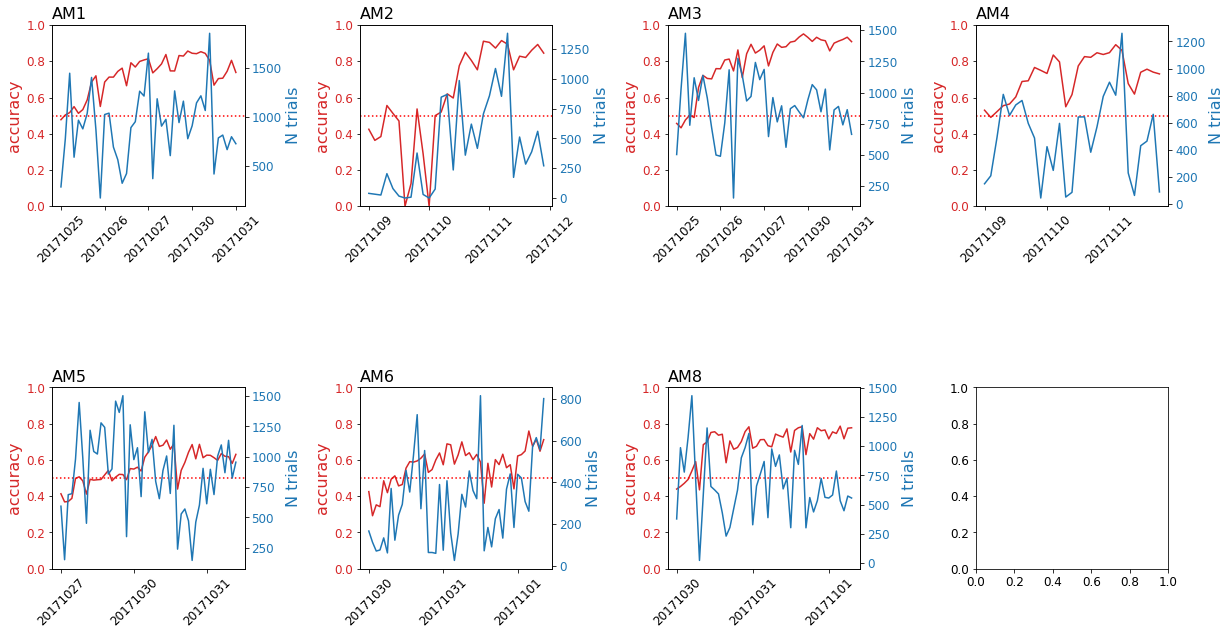

In [992]:
axis_colors = {0: 'tab:red', 1: 'tab:blue'}
figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}

tdf =  standarddf.copy()


for cohort in tdf['cohort'].unique(): #curr_cohort_list:
    nc, nr = figsz[cohort]
    print(nr, nc)
    fig, axes = pl.subplots(nr, nc, figsize=(nc*5,nr*5))
    for ax, (animalid, ddf) in zip(axes.flat, tdf[tdf['cohort']==cohort].groupby(['animalid'])):

        xvs = [s for s, g in ddf.groupby(['sessionid'])]
        xis = np.arange(0, len(xvs))

        yvs= [g['overall_accuracy'].values[0] for s, g in ddf.groupby(['sessionid'])]
        ax.plot(xis, yvs, color=axis_colors[0])

        ax.tick_params(axis='y', labelcolor=axis_colors[0])
        ax.set_ylabel('accuracy', color=axis_colors[0])
        ax.set_ylim([0, 1])
        ax.axhline(y=0.5, linestyle=':', color='r')

        ax.set_xticklabels(xvs, rotation=45)
        #ax.tick_params(axis='x', rotation=45)

        ax2 = ax.twinx()
        twinvs = [g['n_trials'].values[0] for s, g in ddf.groupby(['sessionid'])]
        ax2.plot(xis, twinvs, color=axis_colors[1])
        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylabel('N trials', color=axis_colors[1])

        ax.set_title(animalid, loc='left')
        ax.set_xticklabels(xvs, rotation=45)

    pl.subplots_adjust(hspace=1, wspace=0.6)

    figname = 'by-animal_accuracy-and-ntrials_cohort-%s' % cohort

    pl.savefig(os.path.join(outdir, 'individuals', '%s.png' % figname))

(2, 6)
(2, 8)
(2, 4)


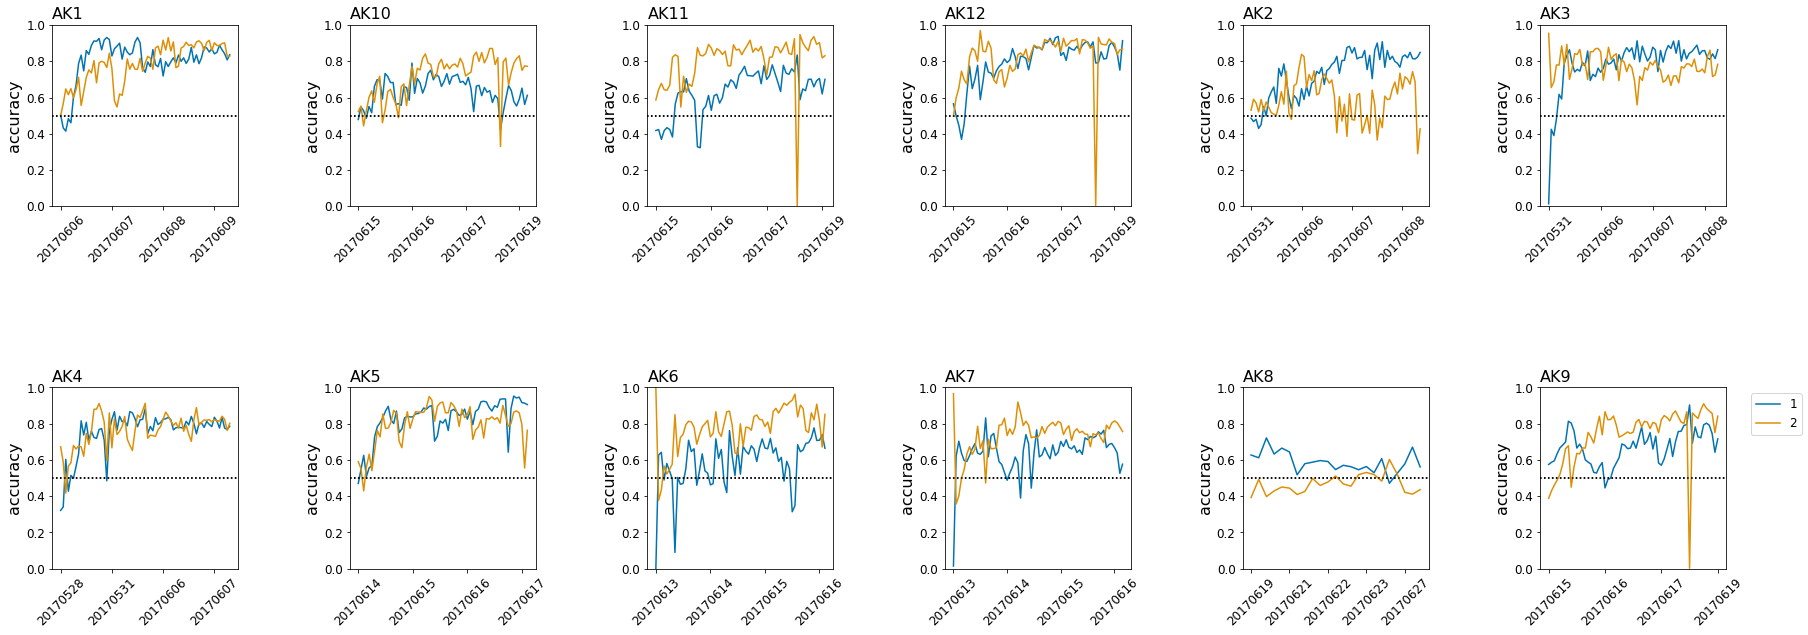

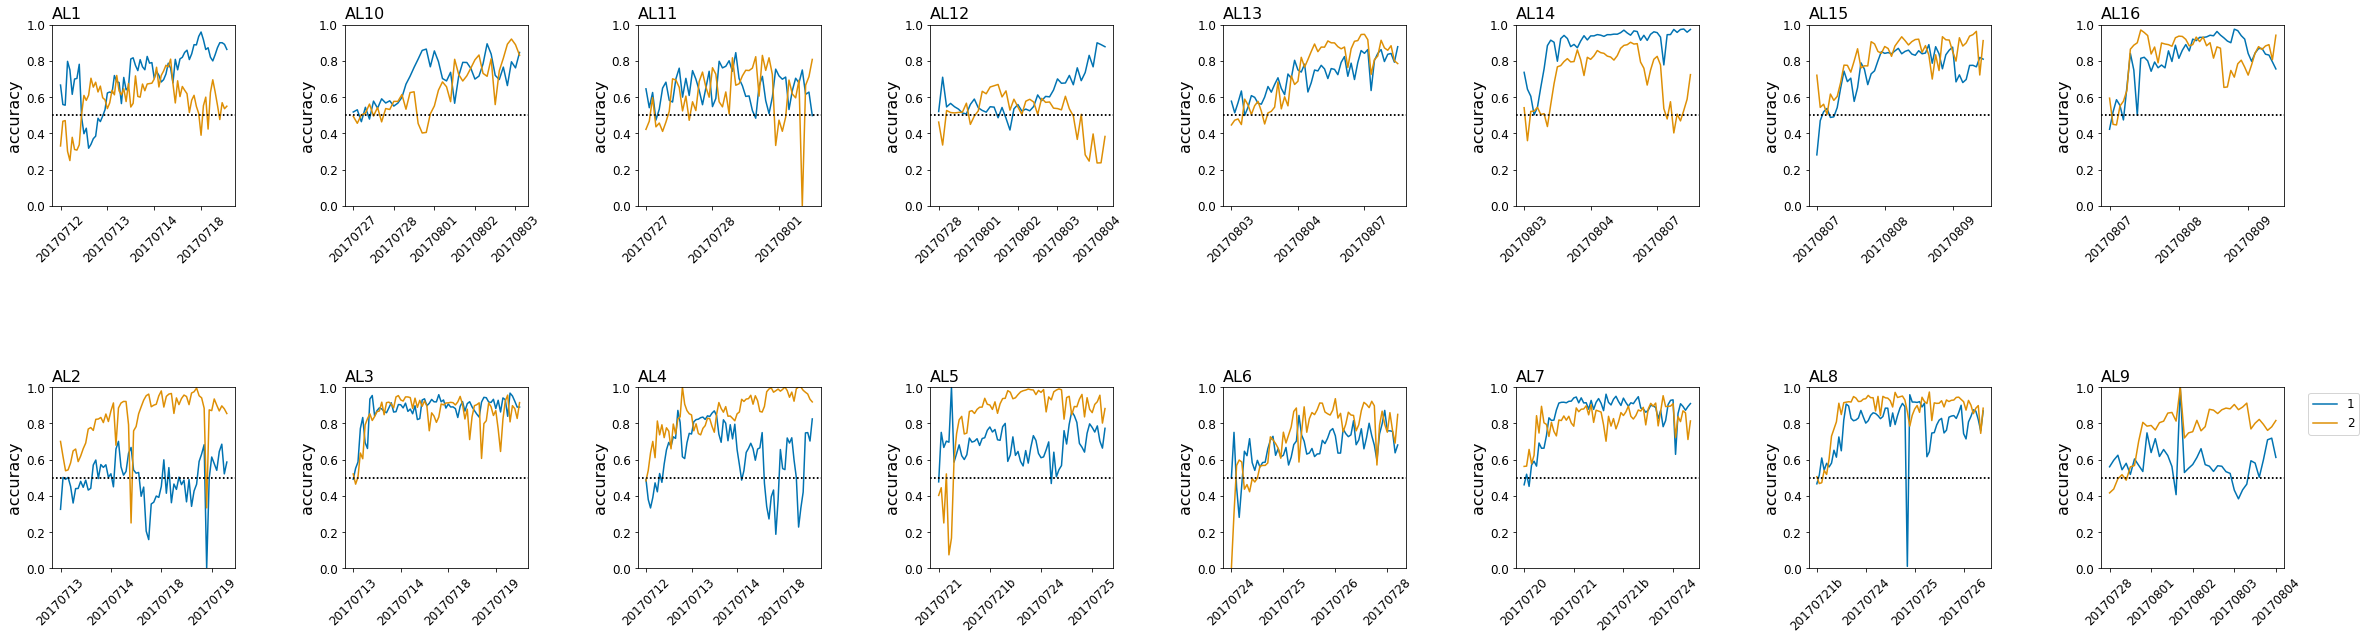

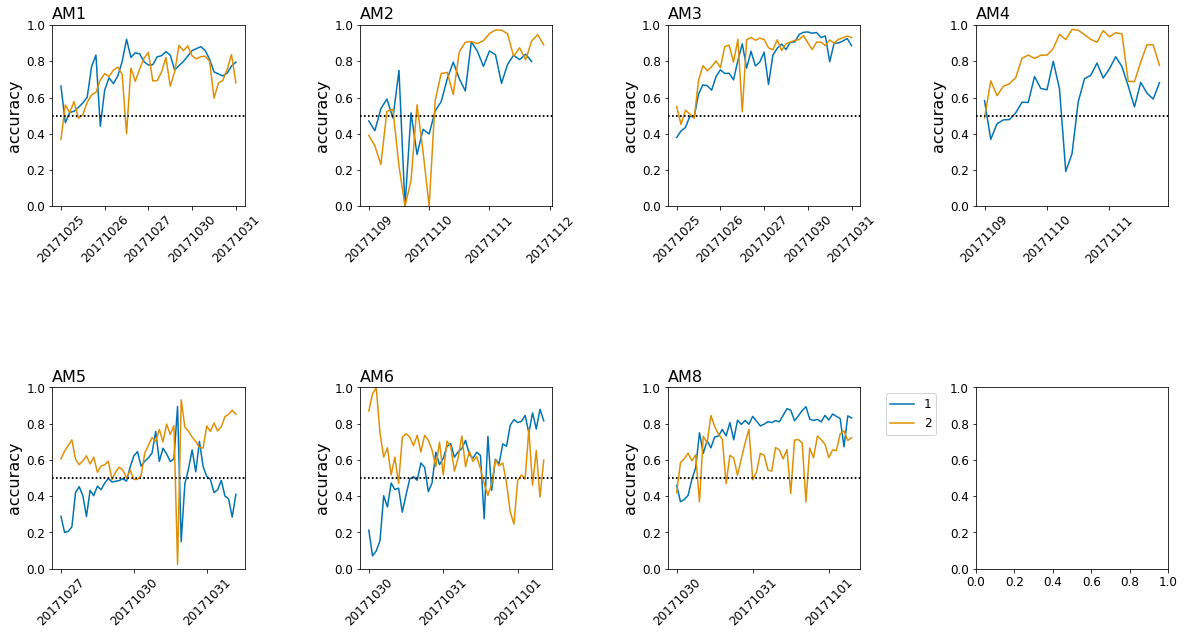

In [1028]:
curr_colors = feature_colors['objectid']

figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}

tdf =  standarddf_split.copy()


for cohort in tdf['cohort'].unique(): #curr_cohort_list:
    nc, nr = figsz[cohort]
    print(nr, nc)
    fig, axes = pl.subplots(nr, nc, figsize=(nc*5,nr*5))
    for ax, (animalid, animaldf) in zip(axes.flat, tdf[tdf['cohort']==cohort].groupby(['animalid'])):
    
        for c_color, ((objectid), odf) in zip(curr_colors, animaldf.groupby(['objectid'])):

            xvs = [s for s, g in odf.groupby(['sessionid'])]
            xis = np.arange(0, len(xvs))

            yvs= [g['split_accuracy'].values[0] for s, g in odf.groupby(['sessionid'])]
            ax.plot(xis, yvs, color=c_color, label=objectid)

            ax.set_ylabel('accuracy')
            ax.set_ylim([0, 1])
            ax.axhline(y=0.5, linestyle=':', color='k')

            ax.set_xticklabels(xvs, rotation=45)
            #ax.tick_params(axis='x', rotation=45)

            ax.set_title(animalid, loc='left')
            ax.set_xticklabels(xvs, rotation=45)

    pl.subplots_adjust(hspace=1, wspace=0.6)
    ax.legend(bbox_to_anchor=(1.1, 1))
    
    figname = 'by-animal_split-accuracy_objectid_cohort-%s' % cohort
    pl.savefig(os.path.join(outdir, 'individuals', '%s.png' % figname))

## Plot stuff for single example animal

In [1034]:
last_session_in_phase = [g.sort_values(by='session')['session'].values[0] for p, g in animaldf.groupby(['phase'])]
last_session_in_phase


[20170531, 20170615, 20170617, 20170620]

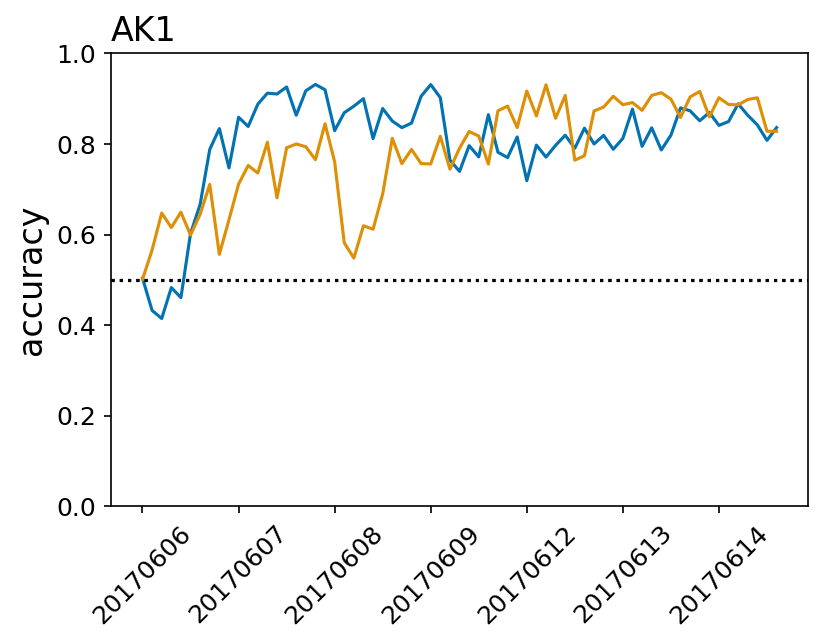

In [1030]:
animalid = 'AK1'
axis_colors = {0: feature_colors['twinx'][0], 
               1:  feature_colors['twinx'][1]}


animaldf = standarddf_split[standarddf_split['animalid']==animalid] 

fig, ax = pl.subplots(figsize=(6, 4), dpi=dpi)


for c_color, ((objectid), objectdf) in zip(curr_colors, animaldf.groupby(['objectid'])):

    session_list = [s for s, g in objectdf.groupby(['sessionid'])]
    session_ixs = np.arange(0, len(session_list))

    yvs= [g['split_accuracy'].values[0] for s, g in objectdf.groupby(['sessionid'])]
    ax.plot(session_ixs, yvs, color=c_color, label=objectid)

    ax.set_ylabel('accuracy')
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, linestyle=':', color='k')

    ax.set_xticklabels(session_list, rotation=45)
    #ax.tick_params(axis='x', rotation=45)

    ax.set_title(animalid, loc='left')
    ax.set_xticklabels(xvs, rotation=45)

for phase_s in       
# ax.tick_params(axis='y', labelcolor=axis_colors[0])
# ax.set_ylabel('accuracy', color=axis_colors[0])
# ax.set_ylim([0, 1])
# ax.axhline(y=0.5, linestyle=':', color='r')

# ax.set_xticklabels(xvs, rotation=45)
# #ax.tick_params(axis='x', rotation=45)

# ax2 = ax.twinx()
# twinvs = [g['n_trials'].values[0] for s, g in ddf.groupby(['sessionid'])]
# ax2.plot(xis, twinvs, color=axis_colors[1])
# ax2.tick_params(axis='y', labelcolor=axis_colors[1])
# ax2.set_ylabel('N trials', color=axis_colors[1])

# ax.set_title(animalid, loc='left')
# ax.set_xticklabels(xvs, rotation=45)

# pl.subplots_adjust(hspace=1, wspace=0.6)

# figname = 'by-animal_accuracy-and-ntrials_cohort-%s' % cohort

# pl.savefig(os.path.join(outdir, 'individuals', '%s.png' % figname))

# Visualize all animals

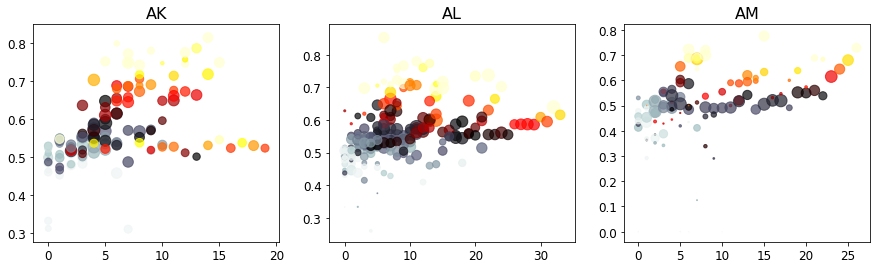

In [541]:
fig, axes = pl.subplots(1, len(curr_cohort_list), figsize=(15, 4))

for (cohort, animalid), g in perfdf_filt.groupby(['cohort', 'animalid']):
    axi = curr_cohort_list.index(cohort)
    ax = axes[axi]
    
    session_list = [s for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    
    ntrials = [sg['n_trials'].values[0]/10. for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]

    ax.scatter(np.arange(0, len(session_list)), mean_acc, c=mean_acc, cmap=pnas_cmap,
               s=ntrials, label=animalid, alpha=0.7)
    ax.set_title(cohort)


In [673]:
perfdf_filt['phase'].unique()

array([1, 2, 3, 5])

In [717]:
perfdf_filt.iloc[0]['sessionid']

'20170531'

33 out of 35 animals with accuracy >= 0.70
('2 did not learn:', ['AK8', 'AL12'])


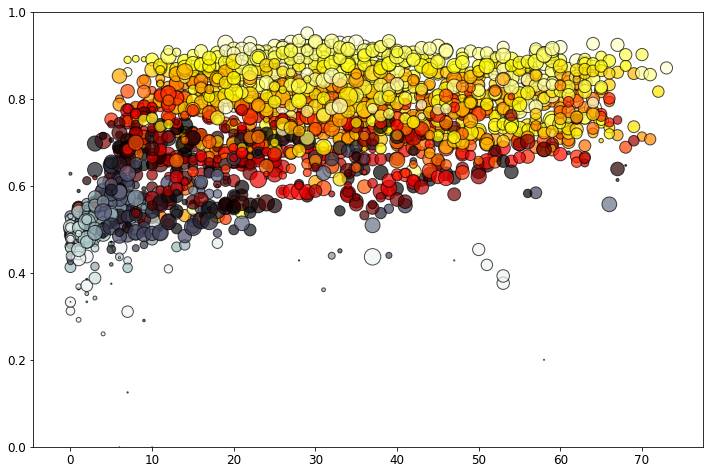

In [993]:
accuracies = {} # []
fig, ax = pl.subplots(figsize=(12, 8))

for (cohort, animalid), g in standarddf.groupby(['cohort', 'animalid']):
    
    session_list = [s for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    
    ntrials = [sg['n_trials'].values[0]/5. for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    
    accuracies.update({animalid: mean_acc})
    
    ax.scatter(np.arange(0, len(session_list)), mean_acc, c=mean_acc, cmap=pnas_cmap,
               s=ntrials, label=animalid, alpha=0.7, edgecolors='k')
    #ax.set_title(cohort)
    
ax.set_ylim([0, 1])

# Print sumamry
thr = 0.7
curr_animal_ids = standarddf['animalid'].unique()
animals_learned = standarddf[standarddf['overall_accuracy'] >= thr]['animalid'].unique()
print("%i out of %i animals with accuracy >= %.2f" % (len(animals_learned), len(curr_animal_ids), thr))
animals_didnt_learn = [i for i in curr_animal_ids if i not in animals_learned]

print("%i did not learn:" % len(animals_didnt_learn), animals_didnt_learn)


# Visualze all performance, sort sessions

In [821]:
max_nsessions = max([len(v) for k, v in accuracies.items()])
print(max_nsessions)

session_counts = dict((k, len(v)) for k, v in accuracies.items())

sorted_session_counts = [k for k, v in sorted(session_counts.items(), key=lambda x: x[1])][::-1] # np.argsort(session_counts)[::-1]


74

In [826]:
#### Create array to plot as heatmap
performance_mat = np.empty((len(curr_animal_ids), max_nsessions))
for ai, animalid in enumerate(sorted_session_counts):
    vals = accuracies[animalid]
    xvpad = np.pad(vals, ((0, max_nsessions-len(vals))), mode='constant', constant_values=np.nan)

    performance_mat[ai, :] = xvpad

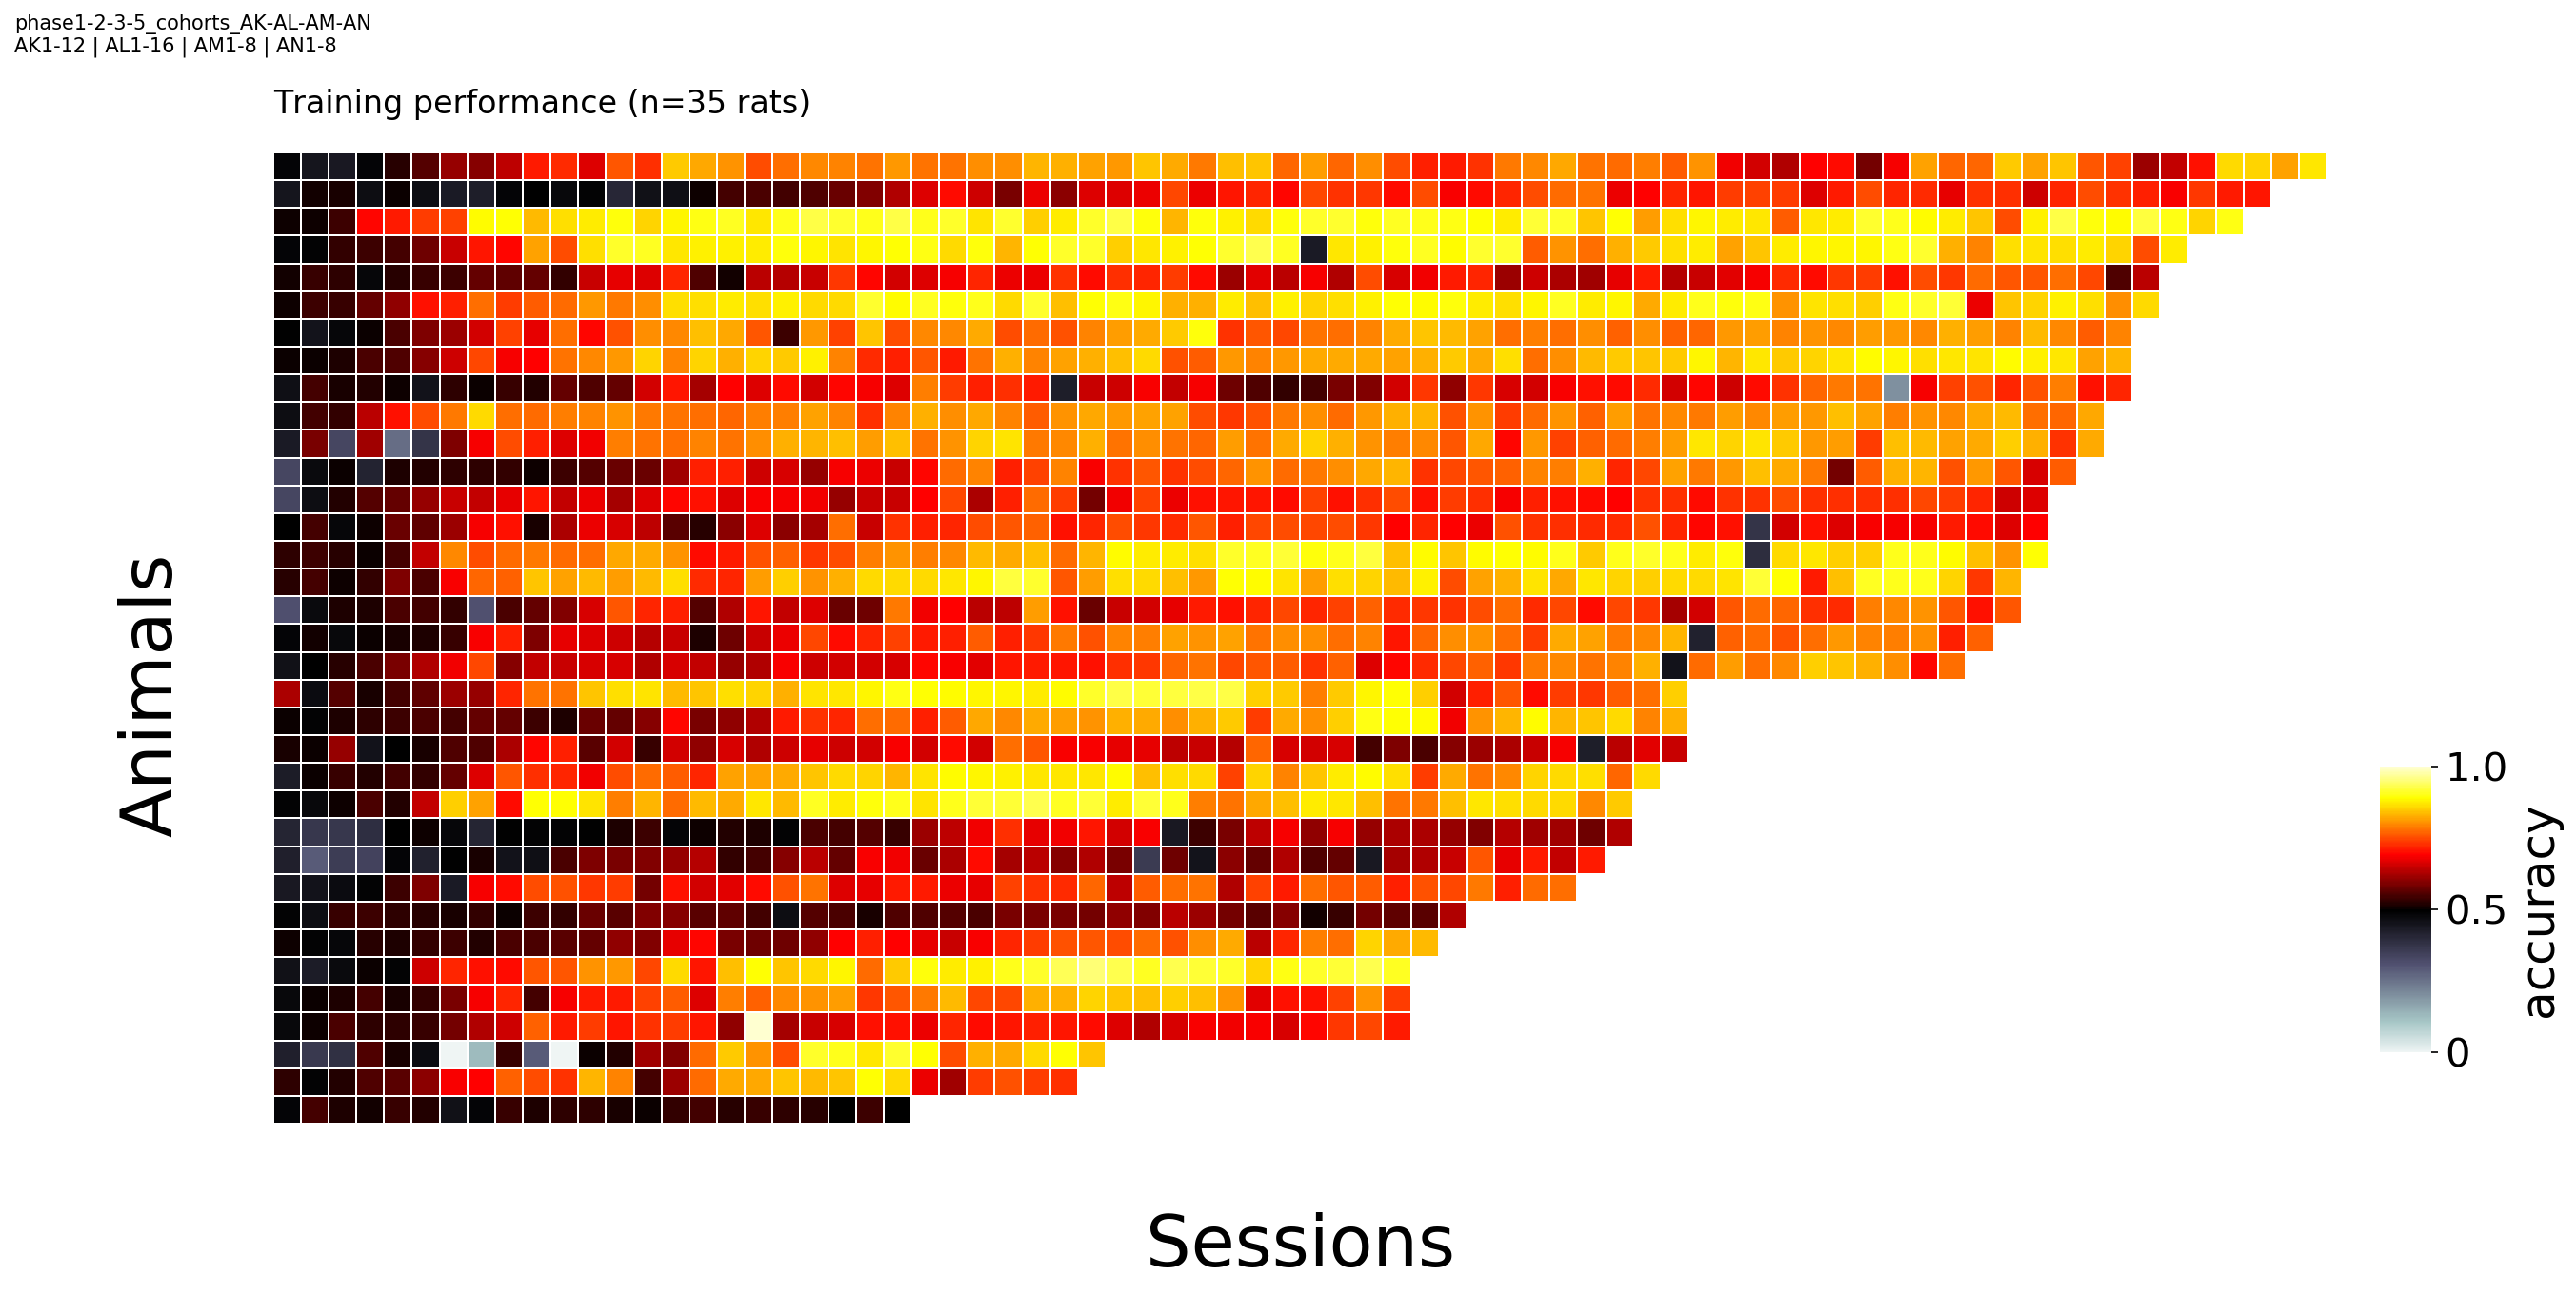

In [872]:
#### Plot performance array
fig, ax =pl.subplots(figsize=(18,10), dpi=dpi)
cbar_ax = fig.add_axes([.92, .25, .02, .2])
fig.patch.set_alpha(0.)
sns.heatmap(performance_mat, cmap=pnas_cmap, vmin=0, vmax=1, linewidths=0.5, square=True,
           cbar_ax=cbar_ax, cbar=1, ax=ax,
           cbar_kws=dict(ticks=[0, .5, 1.0]))
ax.tick_params(axis='x', size=0)
ax.axis('off')

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2)
ax.set_title('Training performance (n=%i rats)' % performance_mat.shape[0], loc='left', pad=20)

fig.text(0.5, 0.1, 'Sessions', ha='center', fontsize=36)
fig.text(0.04, 0.5, 'Animals', va='center', rotation='vertical', fontsize=36)

#cbar_ax.yaxis.label.set_size(20)
cbar_ax.set_yticklabels([0, 0.5, 1.0], fontsize=20) #(20)
cbar_ax.set_ylabel('accuracy', fontsize=24) #(20)

fig.text(0, 0.95, figid)
pl.savefig(os.path.join(outdir, 'all_animals_heatmap_by_session_sorted.png'))
pl.savefig(os.path.join(outdir, 'all_animals_heatmap_by_session_sorted.svg'))

In [27]:
object_ids = df['object'].unique()
HMAPS = dict((animalid, dict((k, []) for k in object_ids)) for animalid in df['animalid'].unique())
no_feedback = {}

    
dlist = []
i=0
for (animalid, session, sfx), agroup in df.groupby(['animalid', 'session', 'suffix']):
    
    if curr_phase in [4, 5] and no_feedback_flag is True:
        no_fb = agroup[agroup['no_feedback']==True][feature_list]
        no_fb_configs = list(set([(s, d) for s, d, in zip(no_fb[row_feature].values, no_fb[col_feature].values)]))
        no_feedback[animalid] = no_fb_configs

    for objectname, ogroup in agroup.groupby(['object']):
        hmap = np.ones((len(row_values), len(col_values))) * np.nan

        for (drot, sz), sgroup in ogroup.groupby([col_feature, row_feature]):

            n_trials = float(sgroup['outcome'].shape[0])
            perc_correct = len(sgroup[sgroup['outcome']=='success']) / n_trials
            mean_rt = sgroup['response_time'].mean()

            r_ix = list(row_values).index(sz)
            c_ix = list(col_values).index(drot)

            hmap[r_ix, c_ix] = perc_correct

            dlist.append(pd.DataFrame({'perc_correct': perc_correct,
                                       'avg_rt': mean_rt,
                                          'n_trials': n_trials,
                                          '%s' % row_feature: sz,
                                          '%s' % col_feature: drot,
                                          'objectid': objectname,
                                          'animalid': animalid,
                                          'session': session,
                                          'suffix': sfx}, index=[i]))
            i+=1

        HMAPS[animalid][objectname].append(hmap)

perfdf = pd.concat(dlist, axis=0)       

for animalid, hmap_d in HMAPS.items():
    HMAPS[animalid] = dict((k, np.dstack(v)) for k, v in hmap_d.items())


# Plot

In [28]:
# font_params = {'legend.fontsize': 'large',
#                  'axes.labelsize': 'large',
#                  'axes.titlesize': 'large',
#                  'xtick.labelsize': 'large',
#                  'ytick.labelsize': 'large'}
font_params = {'legend.fontsize': 22,
                 'axes.labelsize': 36,
                 'axes.titlesize': 22,
                 'xtick.labelsize': 22,
                 'ytick.labelsize': 22}

pl.rcParams.update(font_params)

dpi=150
lw = 5


# Set current output dir for figures

In [30]:
curr_outdir

'/n/coxfs01/behavior-data/threeport/processed/GJ/phase-6/performance'

In [47]:
# if curr_phase == 6:
#     curr_outdir = os.path.join(processed_dir, 'performance', 'inplane_rotations')
# else:
#     curr_outdir = os.path.join(processed_dir, 'performance')

# if not os.path.exists(os.path.join(curr_outdir, 'by_animal')):
#     os.makedirs(os.path.join(curr_outdir, 'by_animal'))
# print(os.path.join(curr_outdir, 'by_animal'))

/n/coxfs01/behavior-data/threeport/processed/performance/by_animal


##### Test HEATMAP w/ 1 animal

In [48]:
len(col_values)*1.3

11.700000000000001

_annot_heatmap_split-object_phase-6_AG1


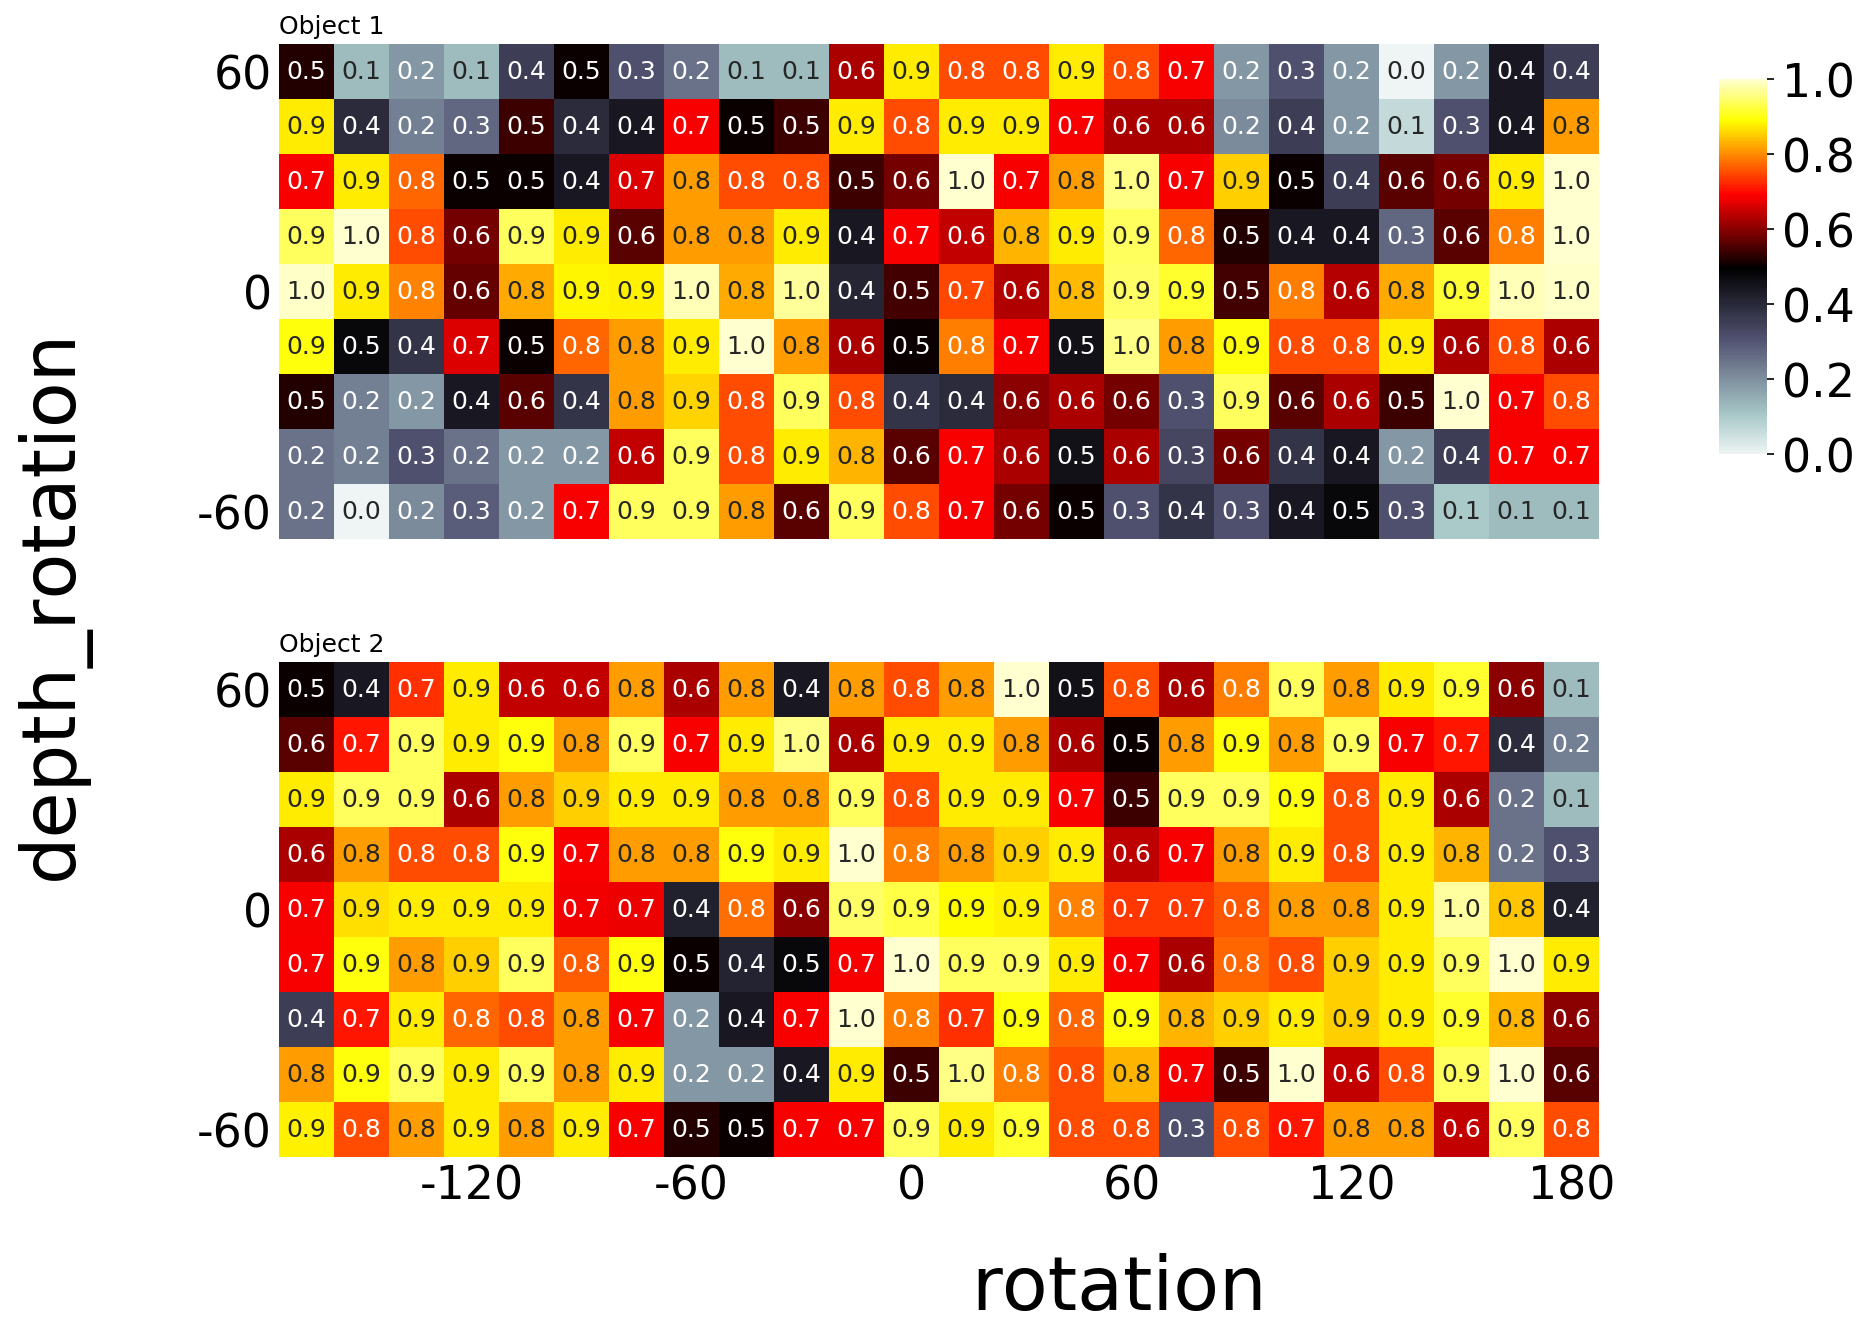

In [32]:
if curr_phase in [4, 5] and no_feedback_flag:
    curr_no_fb = no_feedback[animalid]
else:
    curr_no_fb = None
    
fw = min([ int(round(len(col_values)*1.2)), 16])
fh = len(object_ids)*5

annot=True
annot_str = '_annot_' if annot else ''

fig, axes = pl.subplots(2, 1, figsize=(fw, fh), 
                        dpi=dpi, sharex=True, sharey=True)

cbar_ax = fig.add_axes([0.75, 0.6, 0.02, 0.25])

hmap_d = HMAPS[animalid]
for oi, objectid in enumerate(object_ids):
    ax = axes[oi]
    hmap = np.nanmean(hmap_d[objectid], axis=-1)
    im = sns.heatmap(hmap, cmap=pnas_cmap, vmin=0, vmax=1, ax=ax,
                    cbar=oi==0, cbar_ax=0 if oi else cbar_ax, center=0.5, 
                     annot=annot, fmt=".1f",  annot_kws={"size": 12})

    format_size_depth_ticks(ax, xvals=col_values, yvals=row_values, xmax=xmax, ymax=ymax, seaborn=True)
    if curr_no_fb is not None:
        draw_no_feedback(ax, curr_no_fb, defaults, seaborn=True, lw=6)

    if annot:
        ax.set_title('Object %s' % objectid, fontsize=12, loc='left', pad=5)
    ax.tick_params(axis='both', size=0)

    ax.set_aspect('equal')
    ax.invert_yaxis()

if curr_no_fb is not None:
    ax.legend(bbox_to_anchor=(1.7, 1))

pl.subplots_adjust(hspace=0.2, wspace=0.1, right=0.7, left=0.15)

fig.text(0.5, 0.03, col_feature, ha='center', fontsize=36)
fig.text(0.04, 0.5, row_feature, va='center', rotation='vertical', fontsize=36)

figname = '%sheatmap_split-object_phase-%i_%s' % (annot_str, curr_phase, animalid)
print(figname)

#pl.savefig(os.path.join(curr_outdir, 'by_animal', '%s.svg' % figname))
pl.savefig(os.path.join(curr_outdir, 'by_animal', '%s.png' % figname))


In [921]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/performance'

## Plot HEATMAP for all animals

In [47]:
plot_each_animal = True
transform_str = 'inplane_rotations' if curr_phase==6 else 'indepth_rotations'

#curr_outdir = os.path.join(processed_dir, 'performance', transform_str) #, 'by_animal')

if plot_each_animal:
    
    if not os.path.exists(os.path.join(curr_outdir, 'by_animal')):
        os.makedirs(os.path.join(curr_outdir, 'by_animal'))
print(os.path.join(curr_outdir, 'by_animal'))
                

/n/coxfs01/behavior-data/threeport/processed/GJ/phase-6/performance/by_animal


In [48]:
seaborn = True
annot=True

annot_str = '_annot_' if annot else ''

fw = min([len(col_values)*1.2, 16])
fh = len(object_ids)*5

if plot_each_animal:
    for ai, (animalid, hmap_d) in enumerate(HMAPS.items()):
        
        if curr_phase in [4, 5]:
            curr_no_fb = no_feedback[animalid]
        else:
            curr_no_fb = None

        fig, axes = pl.subplots(2, 1, figsize=(fw, fh), 
                                dpi=dpi, sharex=True, sharey=True)
        
        cbar_ax = fig.add_axes([0.7, 0.6, 0.02, 0.25])

        hmap_d = HMAPS[animalid]
        for oi, objectid in enumerate(object_ids):
            ax = axes[oi]
            hmap = np.nanmean(hmap_d[objectid], axis=-1)
            im = sns.heatmap(hmap, cmap=pnas_cmap, vmin=0, vmax=1, ax=ax,
                            cbar=oi==0, cbar_ax=0 if oi else cbar_ax, center=0.5, 
                             annot=annot, fmt=".1f",  annot_kws={"size": 12})

            format_size_depth_ticks(ax, xvals=col_values, yvals=row_values, xmax=xmax, ymax=ymax, seaborn=True)
            if curr_no_fb is not None:
                draw_no_feedback(ax, curr_no_fb, defaults, seaborn=True, lw=6)

            if annot:
                ax.set_title('Object %s' % objectid, fontsize=12, loc='left', pad=5)
            ax.tick_params(axis='both', size=0)

            ax.set_aspect('equal')
            ax.invert_yaxis()

        if curr_no_fb is not None:
            ax.legend(bbox_to_anchor=(1.7, 1))
            
        pl.subplots_adjust(hspace=0.2, wspace=0.1, right=0.7, left=0.15)

        fig.text(0.5, 0.03, col_feature, ha='center')
        fig.text(0.04, 0.5, row_feature, va='center', rotation='vertical')

        figname = '%sheatmap_split-object_phase-%i_%s' % (annot_str, curr_phase, animalid)
        print(figname)

        #pl.savefig(os.path.join(curr_outdir, 'by_animal', '%s.svg' % figname))
        pl.savefig(os.path.join(curr_outdir, 'by_animal', '%s.png' % figname))

        pl.close()

_annot_heatmap_split-object_phase-6_AJ12
_annot_heatmap_split-object_phase-6_AJ1
_annot_heatmap_split-object_phase-6_AJ4
_annot_heatmap_split-object_phase-6_AJ5
_annot_heatmap_split-object_phase-6_AG8
_annot_heatmap_split-object_phase-6_AG7
_annot_heatmap_split-object_phase-6_AG6
_annot_heatmap_split-object_phase-6_AG5
_annot_heatmap_split-object_phase-6_AG2
_annot_heatmap_split-object_phase-6_AG1


In [42]:
HMAPS.keys()

['AJ12', 'AJ1', 'AJ4', 'AJ5', 'AG8', 'AG7', 'AG6', 'AG5', 'AG2', 'AG1']

heatmap_split-object_phase-6_AG-AJ


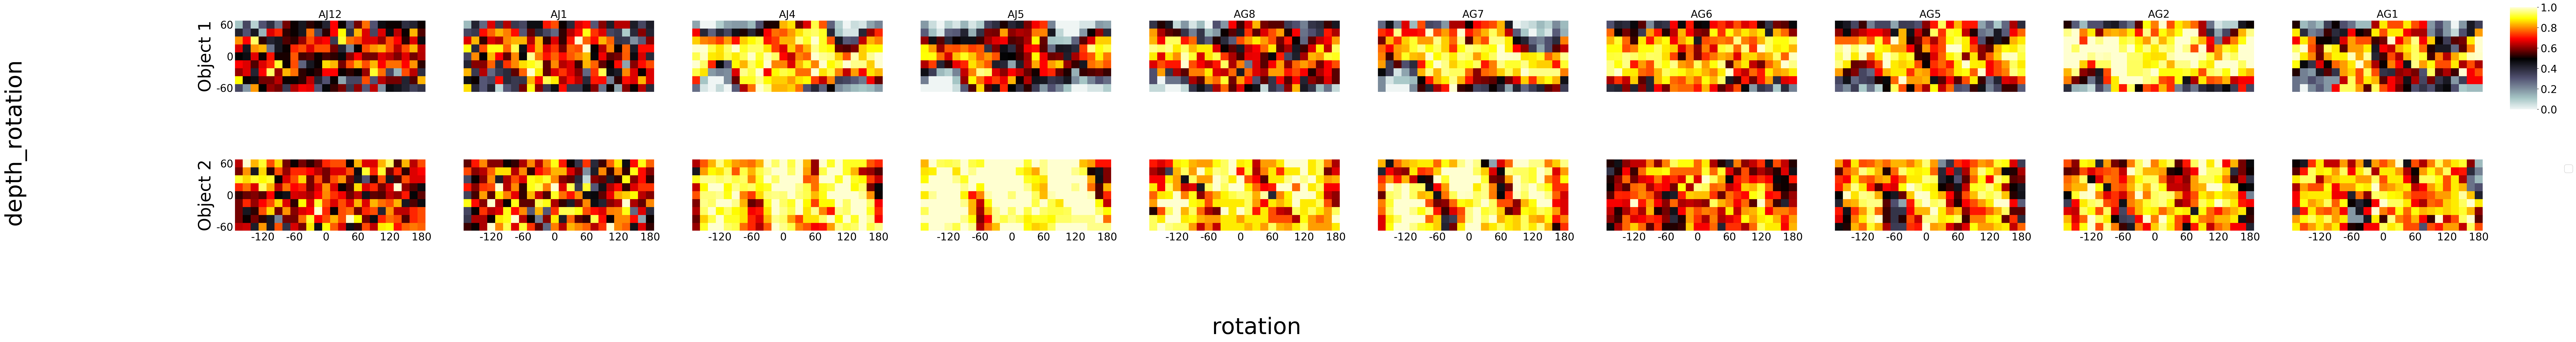

In [52]:
plot_each_animal=False
if not plot_each_animal:
    seaborn = True
    dpi=200

    fig, axes = pl.subplots(2, len(HMAPS.keys()), figsize=(len(animal_ids)*8, len(object_ids)*6), 
                            dpi=150, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.96, 0.58, 0.01, 0.25])

    for ai, (animalid, hmap_d) in enumerate(HMAPS.items()):
        if curr_phase in [4, 5]:
            curr_no_fb = no_feedback[animalid]

        for oi, okey in enumerate(object_ids):
            ax = axes[oi, ai]
            hmap = np.nanmean(hmap_d[okey], axis=-1)
            if seaborn:
                im = sns.heatmap(hmap, cmap=pnas_cmap, vmin=0, vmax=1, ax=ax,
                                cbar=ai==0, cbar_ax=None if ai else cbar_ax)
            else:
                im = ax.imshow(hmap, origin='bottom', cmap=pnas_cmap, vmin=0, vmax=1)

            ax.set_aspect('equal')
            format_size_depth_ticks(ax, xvals=col_values, yvals=row_values, 
                                    xmax=xmax, ymax=ymax, seaborn=seaborn)
            if curr_phase in [4, 5]:
                draw_no_feedback(ax, curr_no_fb, defaults, seaborn=seaborn)
            #ax.set_title(animalid, fontsize=8, loc='left', pad=5)

            ax.tick_params(axis='both', size=0)
            if ai==0:
                ax.set_ylabel('Object %s' % okey)

            if seaborn:
                ax.invert_yaxis()
                
            if oi==0:
                ax.set_title(animalid)

    
    ax.legend(bbox_to_anchor=(1.5, 1))

    if not seaborn:
        cbar_ax = fig.add_axes([1.5, 0.58, 0.01, 0.25])
        fig.colorbar(im, cax=cbar_ax)

    pl.subplots_adjust(hspace=0.0, wspace=0.2, right=0.95, bottom=0.2)

    fig.text(0.5, 0.03, col_feature, ha='center', fontsize=48)
    fig.text(0.04, 0.5, row_feature, va='center', rotation='vertical', fontsize=48)


    figname = 'heatmap_split-object_phase-%i_%s' % (curr_phase, '-'.join(cohort_list))
    print(figname)

    #pl.savefig(os.path.join(curr_outdir, '%s.svg' % figname))
    pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))
    #pl.close()

## Plot no-feedback performance only

In [64]:
curr_outdir = os.path.join(processed_dir, 'performance', 'no_feedback') #, 'by_animal')


In [65]:
twin_metric = 'avg_rt'
curr_metric = 'perc_correct'

dlist = []
incl_animals = [k for k, v in no_feedback.items() if len(v) > 0]
for animalid in incl_animals:
    fb_sizes = [f[0] for f in no_feedback[animalid]]
    fb_drots = [f[1] for f in no_feedback[animalid]]

    avg_accuracy = perfdf[(perfdf['animalid']==animalid) 
                   & (perfdf['size'].isin(fb_sizes)) 
                   & (perfdf['depth_rotation'].isin(fb_drots))].groupby(['session']).mean()[curr_metric]
    
    avg_rt = perfdf[(perfdf['animalid']==animalid) 
                   & (perfdf['size'].isin(fb_sizes)) 
                   & (perfdf['depth_rotation'].isin(fb_drots))].groupby(['session']).mean()[twin_metric]
    
    default_accuracy = perfdf[(perfdf['animalid']==animalid) 
                   & (perfdf['size']==default_size) 
                   & (perfdf['depth_rotation']==default_depth_rotation)].groupby(['session']).mean()[curr_metric]
    
    default_rt = perfdf[(perfdf['animalid']==animalid) 
                   & (perfdf['size']==default_size) 
                   & (perfdf['depth_rotation']==default_depth_rotation)].groupby(['session']).mean()[twin_metric]
    
    relative_accuracy = []
    dlist.append(pd.DataFrame({'mean_accuracy': avg_accuracy,
                              'mean_rt': avg_rt,
                               'default_accuracy': default_accuracy,
                               'default_rt': default_rt,
                              'animalid': [animalid for _ in np.arange(0, len(avg_rt))]}))
    
fb_df = pd.concat(dlist, axis=0).reset_index(drop=True)


In [66]:
fb_df['relative_accuracy'] = fb_df['mean_accuracy'] / fb_df['default_accuracy']
fb_df['relative_rt'] = fb_df['mean_rt'] / fb_df['default_rt']


fb_df = fb_df.replace([np.inf, -np.inf], np.nan).dropna()

fb_animal_ids = sorted(fb_df['animalid'].unique(), key=util.natural_keys)


no_feedback_mean_accuracy-by-animal_AJ


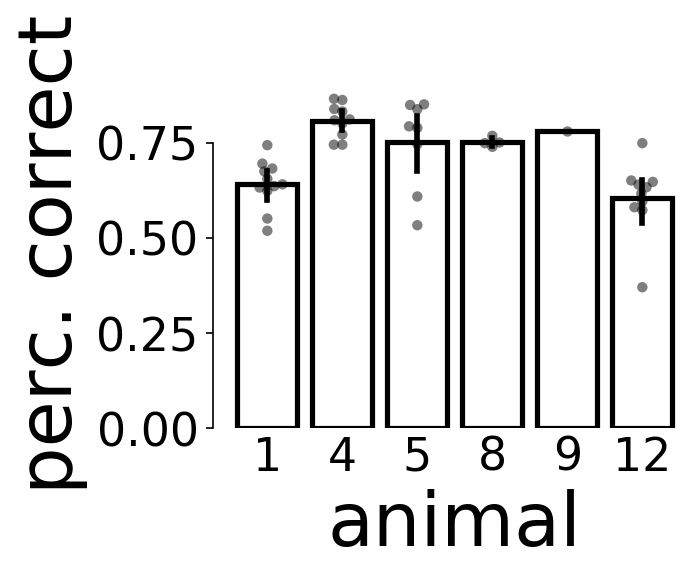

In [71]:
fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

curr_metric = 'mean_accuracy'
sns.barplot(x='animalid', y=curr_metric, order=fb_animal_ids,
            data=fb_df, ax=ax, 
            linewidth=2.5, facecolor=(1, 1, 1, 0),
            errcolor='k', edgecolor='k')
sns.swarmplot(x='animalid', y=curr_metric,  order=fb_animal_ids,
              data=fb_df, ax=ax, color='k', alpha=0.5)
ax.tick_params(axis='x', size=0)

sns.despine(trim=True, offset=8, bottom=True)

ax.set_xticklabels([int(a[2:]) for a in fb_animal_ids])
pl.subplots_adjust(left=0.3, right=0.9, bottom=0.3)
if 'accuracy' in curr_metric:
    ax.set_ylabel('perc. correct')
else:
    ax.set_ylabel('reaction time (s)')
ax.set_xlabel('animal')

figname = 'no_feedback_%s-by-animal_%s' % (curr_metric, cohort)
print(figname)

pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))


In [703]:
[int(a[2:]) for a in fb_animal_ids]

[1, 2, 3, 4, 5, 7, 8]

# General performance and RT